In [1]:
'''
This file includes the exploratory baseline of the new activites generated when using premise
These activites will be further transformed in notebook4.
For now, we're setting up a baseline of impacts in 2020
'''

"\nThis file includes the exploratory baseline of the new activites generated when using premise\nThese activites will be further transformed in notebook4.\nFor now, we're setting up a baseline of impacts in 2020\n"

# Libraries

In [2]:
# Import BW25 packages.
import bw2data as bd
# import bw2io as bi
import bw2calc as bc
import bw2analyzer as bwa

import pandas as pd
import numpy as np
import textwrap

# from collections import defaultdict

import matplotlib.pyplot as plt

In [3]:
# Alias np.NaN to np.nan for backward compatibility
np.NaN = np.nan

# 1. Support Functions

In [4]:
from database_setup import find_activity_by_name_product_location
from lifecycle import run_comprehensive_lcia
from lifecycle import run_comparative_lcia
# from plotting import 

from config import recipe_midpoint_h, activities_li, reference_product_lithium, activities_ni, reference_product_nickel, activities_mn, reference_product_manganese
from plotting import plot_lcia_radar_log, plot_comparative_radar_log_with_colored_table

## 1.1. Functions

In [6]:
def search_and_get_exchanges(database, search_term):
    """
    Search for an activity in the database using the search term, 
    and return all exchanges for the first matching activity.

    Parameters:
    database: The Brightway2 database object to search within.
    search_term: The term to search for in the database.

    Returns:
    list: A list of exchanges for the first activity found using the search term.
    """
    # Perform the search
    search_results = database.search(search_term)
    
    # Get the first result
    if search_results:
        first_result = search_results[0]
        
        # Get all exchanges
        exchanges = list(first_result.exchanges())
        return exchanges
    else:
        return None


## 1.2. Visuals

In [7]:
def plot_lcia_heatmap(lcia_results, activity_name):
    """
    Plot LCIA results as a heatmap.
    
    Parameters:
    - lcia_results: A dictionary with impact categories as keys and scores as values.
    - activity_name: The name of the activity (for the title).
    """
    # Convert the results to a DataFrame
    df = pd.DataFrame(list(lcia_results.items()), columns=['Impact Category', 'Score'])
    df.set_index('Impact Category', inplace=True)
    
    # Plotting the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(df.T, annot=True, cmap='YlGnBu', cbar=True)
    plt.title(f'LCIA Results for {activity_name}')
    plt.xlabel('Impact Category')
    plt.ylabel('Score')
    plt.show()


In [8]:
def plot_lcia_heatmap_matplotlib(lcia_results, activity_name):
    """
    Plot LCIA results as a heatmap using Matplotlib.
    
    Parameters:
    - lcia_results: A dictionary with impact categories as keys and scores as values.
    - activity_name: The name of the activity (for the title).
    """
    # Convert the results to a DataFrame
    df = pd.DataFrame(list(lcia_results.items()), columns=['Impact Category', 'Score'])
    df.set_index('Impact Category', inplace=True)
    
    # Plotting the heatmap using Matplotlib
    fig, ax = plt.subplots(figsize=(10, 8))
    heatmap = ax.imshow(df.T, cmap='YlGnBu', aspect='auto')

    # Adding color bar
    cbar = fig.colorbar(heatmap)
    cbar.set_label('Score')

    # Setting axis labels
    ax.set_xticks(range(len(df.index)))
    ax.set_yticks(range(len(df.columns)))
    ax.set_xticklabels(df.index, rotation=45, ha="right", fontsize=10)
    ax.set_yticklabels(df.columns, fontsize=10)
    ax.set_xlabel('Impact Category')
    ax.set_ylabel('Score')
    
    # Setting the title
    ax.set_title(f'LCIA Results for {activity_name}', fontsize=14)
    
    plt.show()


In [27]:
def plot_lcia_log_bar(lcia_results, activity_name):
    """
    Plot LCIA results as a bar plot with a logarithmic scale using Matplotlib.
    
    Parameters:
    - lcia_results: A dictionary with impact categories as keys and scores as values.
    - activity_name: The name of the activity (for the title).
    """
    # Convert the results to a DataFrame
    df = pd.DataFrame(list(lcia_results.items()), columns=['Impact Category', 'Score'])
    df.set_index('Impact Category', inplace=True)
    
    # Plotting the bar plot with a log scale
    df['Score'].plot(kind='bar', logy=True, figsize=(12, 8))
    
    plt.title(f'LCIA Results for {activity_name} (Log Scale)')
    plt.xlabel('Impact Category')
    plt.ylabel('Log of Score')
    plt.show()


In [28]:
def plot_lcia_radar(lcia_results, activity_name):
    """
    Plot LCIA results as a radar chart using Matplotlib.
    
    Parameters:
    - lcia_results: A dictionary with impact categories as keys and scores as values.
    - activity_name: The name of the activity (for the title).
    """
    # Convert the results to a DataFrame
    df = pd.DataFrame(list(lcia_results.items()), columns=['Impact Category', 'Score'])
    categories = df['Impact Category'].values
    scores = df['Score'].values

    # Number of variables
    N = len(categories)

    # Angle of each axis
    angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()

    # Plot data
    fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(polar=True))
    ax.fill(angles, scores, color='blue', alpha=0.25)
    ax.plot(angles, scores, color='blue', linewidth=2)

    # Labels
    ax.set_yticklabels([])
    ax.set_xticks(angles)
    ax.set_xticklabels(categories, fontsize=10)
    
    plt.title(f'LCIA Results for {activity_name}', size=14, color='blue', y=1.1)
    plt.show()


In [54]:
'''def plot_lcia_radar_log(lcia_results, activity_name, reference_product=None, location=None, wrap_width=20):
    """
    Plot LCIA results as a radar chart with logarithmic values using Matplotlib and annotate with actual values
    underneath the impact category labels.
    
    Parameters:
    - lcia_results: A dictionary with impact categories as keys (tuples) and scores as values.
    - activity_name: The name of the activity (for the title).
    - wrap_width: The width (number of characters) at which to wrap the labels.
    """
    # Extract only the second element of each impact category for labels
    categories = [textwrap.fill(key[1], wrap_width) for key in lcia_results.keys()]
    scores = list(lcia_results.values())
    
    # Apply logarithmic transformation
    log_scores = np.log10(scores)
    
    # Number of variables
    N = len(categories)

    # Angle of each axis
    angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()

    # Complete the loop by repeating the first angle and score (but not the category)
    log_scores = np.concatenate((log_scores, [log_scores[0]]))
    angles += angles[:1]

    # Plot data
    fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(polar=True))
    ax.fill(angles, log_scores, color='blue', alpha=0.25)
    ax.plot(angles, log_scores, color='blue', linewidth=2)

    # Annotate each point with the actual value underneath the labels
    for i, (angle, score, category) in enumerate(zip(angles[:-1], log_scores[:-1], categories)):
        ax.text(angle, score - 0.3, f'{scores[i]:.2e}', horizontalalignment='center', size=10, color='black',
                verticalalignment='top')

    # Labels
    ax.set_yticklabels([])
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, fontsize=10)

    # Adjust for better layout
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
    
    # Add a title
    plt.title(f'LCIA Results for {activity_name} (Log Scale) \n ref:{reference_product} \n  loc:{location}', size=14, color='blue', y=1.1)

    plt.show()'''

In [30]:
def plot_comparative_radar_log(comparative_results, methods_list, wrap_width=20):
    """
    Plot comparative LCIA results for multiple activities on a radar chart with logarithmic values
    and place the legend at the bottom, displaying only one entry per activity.
    
    Parameters:
    - comparative_results: A dictionary with activity names as keys and LCIA results as values.
    - methods_list: A list of tuples representing the impact assessment methods.
    - wrap_width: The width (number of characters) at which to wrap the labels.
    """
    categories = [textwrap.fill(method[1], wrap_width) for method in methods_list]
    N = len(categories)
    angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()

    # Initialize the plot
    fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(polar=True))

    # Plot data for each activity
    for activity_name, lcia_results in comparative_results.items():
        scores = [lcia_results[method] for method in methods_list]
        log_scores = np.log10(scores)
        log_scores = np.concatenate((log_scores, [log_scores[0]]))
        ax.fill(angles + angles[:1], log_scores, alpha=0.25)  # Do not include label here
        ax.plot(angles + angles[:1], log_scores, linewidth=2, label=activity_name)  # Include label here

    # Set the category labels
    ax.set_yticklabels([])
    ax.set_xticks(angles)
    ax.set_xticklabels(categories, fontsize=10)

    # Add a legend at the bottom with only the line entries
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)
    plt.title('Comparative LCIA Results (Log Scale)', size=14, color='blue', y=1.1)
    
    plt.show()

In [31]:
'''def plot_comparative_radar_log_with_colored_table(comparative_results, methods_list, wrap_width=20, header_wrap_width=15):
    """
    Plot comparative LCIA results for multiple activities on a radar chart with logarithmic values,
    and include a table with colored headers (without text) matching the radar plot legend.
    
    Parameters:
    - comparative_results: A dictionary with activity names as keys and LCIA results as values.
    - methods_list: A list of tuples representing the impact assessment methods.
    - wrap_width: The width (number of characters) at which to wrap the impact category labels.
    - header_wrap_width: The width (number of characters) at which to wrap the header (activity names).
    """
    categories = [textwrap.fill(method[1], wrap_width) for method in methods_list]
    N = len(categories)
    angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()

    # Initialize the plot with a larger size
    fig, ax = plt.subplots(figsize=(20, 15), subplot_kw=dict(polar=True))

    colors = []
    
    # Plot data for each activity and collect the colors
    for activity_name, lcia_results in comparative_results.items():
        scores = [lcia_results[method] for method in methods_list]
        log_scores = np.log10(scores)
        log_scores = np.concatenate((log_scores, [log_scores[0]]))
        radar_plot = ax.plot(angles + angles[:1], log_scores, linewidth=2, label=activity_name)
        colors.append(radar_plot[0].get_color())  # Store the color used in the plot

    # Set the category labels
    ax.set_yticklabels([])  # Remove the radial labels
    ax.set_xticks(angles)
    ax.set_xticklabels(categories, fontsize=10)

    # Remove the radial grid labels for a cleaner look
    radial_ticks = [-4, -3, -2, -1, 0]  # Corresponds to 10^-4, 10^-3, 10^-2, 10^-1, 10^0
    ax.set_rgrids(radial_ticks, labels=[], angle=0)

    # Add a legend at the bottom
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)

    # Prepare the table data
    wrapped_header = ['Impact Category'] + [textwrap.fill(activity, header_wrap_width) for activity in comparative_results.keys()]
    table_data = []
    
    for i, method in enumerate(methods_list):
        category = method[1]
        row = [textwrap.fill(category, wrap_width)] + [f'{comparative_results[activity].get(method, 0):.2e}' for activity in comparative_results.keys()]
        table_data.append(row)

    # Create the table
    table = plt.table(cellText=table_data,
                      colLabels=wrapped_header,
                      cellLoc='center',
                      loc='right',
                      bbox=[1.3, 0, 0.5, 1])  # Move the table further right

    # Manually set the font size and adjust cell properties
    table.auto_set_font_size(False)
    table.set_fontsize(6)  # Set the font size of the table to 6
    
    # Color the header cells according to the radar plot colors and remove text
    for i in range(1, len(wrapped_header)):
        cell = table[0, i]
        cell.set_text_props(text='')
        cell.set_facecolor(colors[i-1])
    
    # Adjust the column widths and row heights
    for (i, j), cell in table.get_celld().items():
        if j == 0:  # Widen the impact category column
            cell.set_width(0.3)
        else:
            cell.set_width(0.2)
        
        if i > 0:  # Widen the height of the rows presenting the impact results
            cell.set_height(0.05)  # Adjust this value to make rows taller

    plt.title('Comparative LCIA Results (Log Scale)', size=14, color='blue', y=1.1)
    plt.subplots_adjust(left=0.1, right=0.8, top=0.9, bottom=0.2)  # Adjust layout to give more space for the table

    plt.show()
'''

In [14]:
## TBD:
# def plot_comparative_radar_log_with_colored_table_for_endpoint
## Write a nicer looking radar for endpoint RECIPE (3 metrics)

## 1.3. Lists

In [5]:
# List to access all available impact assessment methods
methods = list(bd.methods)
for method in methods:
    print(method)

In [16]:
'''recipe_endpoint_h_a = [
    ('ReCiPe Endpoint (H,A)', 'human health', 'total'),
    ('ReCiPe Endpoint (H,A)', 'ecosystem quality', 'total'),
    ('ReCiPe Endpoint (H,A)', 'resources', 'total')
]'''

In [17]:
databases_remindSSP1_Base = [
    'ecoinvent_cutoff_3.8_remind_SSP1-Base_2020',
    'ecoinvent_cutoff_3.8_remind_SSP1-Base_2025',
    'ecoinvent_cutoff_3.8_remind_SSP1-Base_2030',
    'ecoinvent_cutoff_3.8_remind_SSP1-Base_2035',
    'ecoinvent_cutoff_3.8_remind_SSP1-Base_2040',
    'ecoinvent_cutoff_3.8_remind_SSP1-Base_2045',
    'ecoinvent_cutoff_3.8_remind_SSP1-Base_2050'
]

# 2. Imports and Declarations

In [6]:
#Creating/accessing the project
bd.projects.set_current("LNV-EI38-202502025")

In [7]:
list(bd.databases)

['biosphere3',
 'ecoinvent 3.8 cutoff',
 'EI38_cutoff_remind_SSP1-Base_2020_baseline',
 'EI38_cutoff_remind_SSP1-Base_2025_baseline',
 'EI38_cutoff_remind_SSP1-Base_2030_baseline',
 'EI38_cutoff_remind_SSP1-Base_2035_baseline',
 'EI38_cutoff_remind_SSP1-Base_2040_baseline',
 'EI38_cutoff_remind_SSP2-Base_2020_baseline',
 'EI38_cutoff_remind_SSP2-Base_2025_baseline',
 'EI38_cutoff_remind_SSP2-Base_2030_baseline',
 'EI38_cutoff_remind_SSP2-Base_2035_baseline',
 'EI38_cutoff_remind_SSP2-Base_2040_baseline',
 'EI38_cutoff_remind_SSP5-Base_2020_baseline',
 'EI38_cutoff_remind_SSP5-Base_2025_baseline',
 'EI38_cutoff_remind_SSP5-Base_2030_baseline',
 'EI38_cutoff_remind_SSP5-Base_2035_baseline',
 'EI38_cutoff_remind_SSP5-Base_2040_baseline']

In [8]:
# Sanity check:
# EcoInvent 3.8 has a length of 19565
len(bd.Database('ecoinvent 3.8 cutoff'))

19565

In [9]:
# We'll be looking only at the original dataset
db_name = 'ecoinvent 3.8 cutoff'

# 3. Lithium

## 3.1. Lithium Carbonate

In [10]:
# Find the activity
activity_name = 'market for lithium carbonate'
reference_product = reference_product_lithium
activity = find_activity_by_name_product_location(db_name, activity_name)

In [11]:
list(activity.exchanges())

[Exchange: 0.2088 ton kilometer 'market group for transport, freight, lorry, unspecified' (ton kilometer, GLO, None) to 'market for lithium carbonate' (kilogram, GLO, None)>,
 Exchange: 0.0246 ton kilometer 'market group for transport, freight, inland waterways, barge' (ton kilometer, GLO, None) to 'market for lithium carbonate' (kilogram, GLO, None)>,
 Exchange: 0.599 ton kilometer 'market for transport, freight, sea, container ship' (ton kilometer, GLO, None) to 'market for lithium carbonate' (kilogram, GLO, None)>,
 Exchange: 1.0 kilogram 'market for lithium carbonate' (kilogram, GLO, None) to 'market for lithium carbonate' (kilogram, GLO, None)>,
 Exchange: 0.3091 ton kilometer 'market group for transport, freight train' (ton kilometer, GLO, None) to 'market for lithium carbonate' (kilogram, GLO, None)>,
 Exchange: 0.339714259034457 kilogram 'lithium carbonate production, from concentrated brine' (kilogram, GLO, None) to 'market for lithium carbonate' (kilogram, GLO, None)>,
 Excha

In [12]:
lcia_results = run_comprehensive_lcia(activity, recipe_midpoint_h)

('ReCiPe Midpoint (H)', 'terrestrial ecotoxicity', 'TETPinf'): 0.0008989654852379075
('ReCiPe Midpoint (H)', 'natural land transformation', 'NLTP'): 0.0011419493023072148
('ReCiPe Midpoint (H)', 'photochemical oxidant formation', 'POFP'): 0.03316888171619653
('ReCiPe Midpoint (H)', 'human toxicity', 'HTPinf'): 3.7660166215077284
('ReCiPe Midpoint (H)', 'marine eutrophication', 'MEP'): 0.03135331176398922
('ReCiPe Midpoint (H)', 'climate change', 'GWP100'): 7.494402553505366
('ReCiPe Midpoint (H)', 'particulate matter formation', 'PMFP'): 0.028131332235116813
('ReCiPe Midpoint (H)', 'agricultural land occupation', 'ALOP'): 0.3105564678863914
('ReCiPe Midpoint (H)', 'freshwater eutrophication', 'FEP'): 0.004629672034834356
('ReCiPe Midpoint (H)', 'metal depletion', 'MDP'): 0.7487683369664381
('ReCiPe Midpoint (H)', 'terrestrial acidification', 'TAP100'): 0.05437900904691242
('ReCiPe Midpoint (H)', 'water depletion', 'WDP'): 0.08776419622440235
('ReCiPe Midpoint (H)', 'urban land occupati

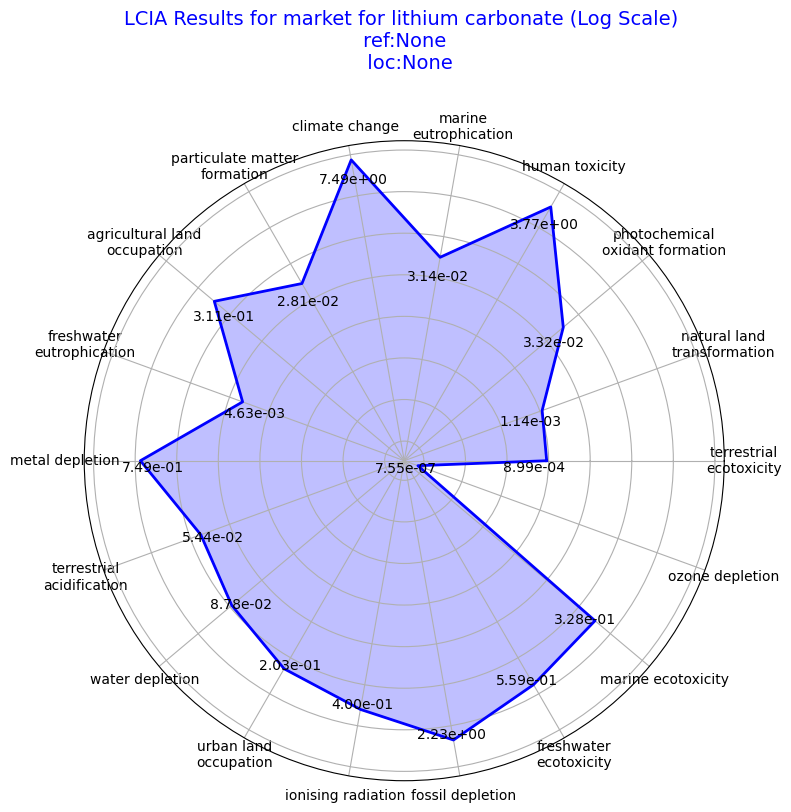

In [13]:
plot_lcia_radar_log(lcia_results, activity_name)

In [14]:
'''
Let's explore the activiies:
    'lithium carbonate production, from concentrated brine',
    'lithium carbonate production, from spodumene', # From RoW
    'lithium carbonate production, from spodumene' # From CN
'''

"\nLet's explore the activiies:\n    'lithium carbonate production, from concentrated brine',\n    'lithium carbonate production, from spodumene', # From RoW\n    'lithium carbonate production, from spodumene' # From CN\n"

### 3.1.1. lithium carbonate production, from concentrated brine

In [15]:
activity_name = 'lithium carbonate production, from concentrated brine'
activity = find_activity_by_name_product_location(db_name, activity_name)

In [16]:
# To view the inventory:
for exc in activity.exchanges():
    print(f"Input: {exc.input} | Amount: {exc['amount']}")

Input: 'market for lithium brine, 6.7 % Li' (kilogram, GLO, None) | Amount: 4.19
Input: 'market for diesel, burned in building machine' (megajoule, GLO, None) | Amount: 1.88
Input: 'market for 2-methyl-2-butanol' (kilogram, GLO, None) | Amount: 0.000545
Input: 'lithium carbonate production, from concentrated brine' (kilogram, GLO, None) | Amount: 1.0
Input: 'market group for electricity, medium voltage' (kilowatt hour, GLO, None) | Amount: 0.58
Input: 'market for chemical factory, organics' (unit, GLO, None) | Amount: 4e-10
Input: 'market group for heat, district or industrial, natural gas' (megajoule, GLO, None) | Amount: 2.963532477
Input: 'market for soda ash, light, crystalline, heptahydrate' (kilogram, GLO, None) | Amount: 2.12
Input: 'market for sodium hydroxide, without water, in 50% solution state' (kilogram, GLO, None) | Amount: 0.0001875
Input: 'market for solvent, organic' (kilogram, GLO, None) | Amount: 2.08e-05
Input: 'market for activated bentonite' (kilogram, GLO, None) 

In [17]:
# Select ReCiPe Midpoint (H) method
method = ('ReCiPe Midpoint (H)', 'climate change', 'GWP100')  # Example impact category, you can choose others

In [18]:
# Perform the LCIA
lca = bc.LCA({activity: 1}, method)
lca.lci()  # Run Life Cycle Inventory
lca.lcia()  # Run Life Cycle Impact Assessment

# Print the total LCIA score
print(f"LCIA Score: {lca.score}")

LCIA Score: 2.0750005807610328


In [19]:
# Perform contribution analysis
contributions = bwa.ContributionAnalysis().annotated_top_processes(lca, limit=10)  # Adjust the limit as an integer
for contribution in contributions:
    print(f"Contribution: {contribution[1]} | Activity: {contribution[2]} | Amount: {contribution[0]}")


Contribution: 3.4540148878595662 | Activity: 'heat production, at hard coal industrial furnace 1-10MW' (megajoule, RoW, None) | Amount: 0.39741896220174133
Contribution: 2.7688717705940946 | Activity: 'diesel, burned in building machine' (megajoule, GLO, None) | Amount: 0.20469756456665575
Contribution: 0.07316437859964205 | Activity: 'quicklime production, in pieces, loose' (kilogram, RoW, None) | Amount: 0.07895069015632558
Contribution: 0.19697443106524115 | Activity: 'hard coal mine operation and hard coal preparation' (kilogram, CN, None) | Amount: 0.06731008316025254
Contribution: 0.4312772612604227 | Activity: 'heat production, at hard coal industrial furnace 1-10MW' (megajoule, Europe without Switzerland, None) | Amount: 0.04962276282993693
Contribution: 0.40988984157764985 | Activity: 'heat production, heavy fuel oil, at industrial furnace 1MW' (megajoule, RoW, None) | Amount: 0.03422079772383613
Contribution: 0.9039554791906265 | Activity: 'heat and power co-generation, natur

In [20]:
lcia_results = run_comprehensive_lcia(activity, recipe_midpoint_h)

('ReCiPe Midpoint (H)', 'terrestrial ecotoxicity', 'TETPinf'): 0.000279796094022033
('ReCiPe Midpoint (H)', 'natural land transformation', 'NLTP'): 0.0006095939942018074
('ReCiPe Midpoint (H)', 'photochemical oxidant formation', 'POFP'): 0.00998077435120156
('ReCiPe Midpoint (H)', 'human toxicity', 'HTPinf'): 1.4385886686929292
('ReCiPe Midpoint (H)', 'marine eutrophication', 'MEP'): 0.008521145786293535
('ReCiPe Midpoint (H)', 'climate change', 'GWP100'): 2.0750005807610328
('ReCiPe Midpoint (H)', 'particulate matter formation', 'PMFP'): 0.005997127751129825
('ReCiPe Midpoint (H)', 'agricultural land occupation', 'ALOP'): 0.20986216501923322
('ReCiPe Midpoint (H)', 'freshwater eutrophication', 'FEP'): 0.0019771462377554715
('ReCiPe Midpoint (H)', 'metal depletion', 'MDP'): 0.2392236514749893
('ReCiPe Midpoint (H)', 'terrestrial acidification', 'TAP100'): 0.015534855771410254
('ReCiPe Midpoint (H)', 'water depletion', 'WDP'): 0.005319761192097448
('ReCiPe Midpoint (H)', 'urban land occ

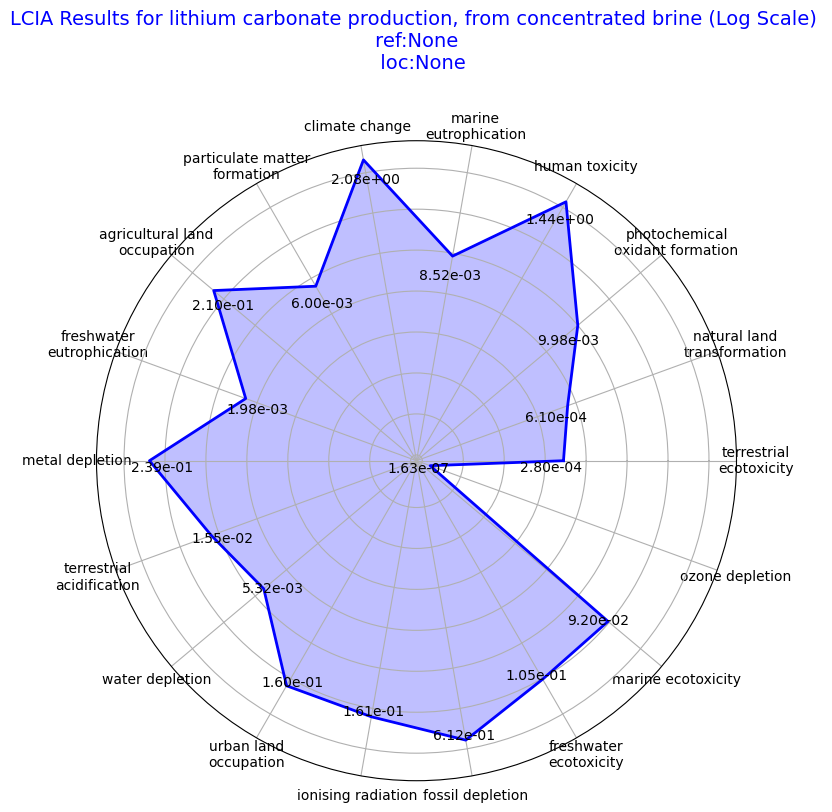

In [21]:
plot_lcia_radar_log(lcia_results, activity_name)

### 3.1.2. lithium carbonate production, from Salar de Olaroz

In [22]:
activity_name = 'lithium carbonate production, from spodumene'
activity = find_activity_by_name_product_location(db_name, activity_name, location='CN')

In [23]:
lcia_results = run_comprehensive_lcia(activity, recipe_midpoint_h)

('ReCiPe Midpoint (H)', 'terrestrial ecotoxicity', 'TETPinf'): 0.0013002901649301472
('ReCiPe Midpoint (H)', 'natural land transformation', 'NLTP'): 0.0013178490864093908
('ReCiPe Midpoint (H)', 'photochemical oxidant formation', 'POFP'): 0.04672829427933812
('ReCiPe Midpoint (H)', 'human toxicity', 'HTPinf'): 5.476068384436381
('ReCiPe Midpoint (H)', 'marine eutrophication', 'MEP'): 0.04372487286587501
('ReCiPe Midpoint (H)', 'climate change', 'GWP100'): 10.570638949991858
('ReCiPe Midpoint (H)', 'particulate matter formation', 'PMFP'): 0.04050281981843309
('ReCiPe Midpoint (H)', 'agricultural land occupation', 'ALOP'): 0.35816114346031674
('ReCiPe Midpoint (H)', 'freshwater eutrophication', 'FEP'): 0.006025979934194211
('ReCiPe Midpoint (H)', 'metal depletion', 'MDP'): 1.1555530394665499
('ReCiPe Midpoint (H)', 'terrestrial acidification', 'TAP100'): 0.0757980784492239
('ReCiPe Midpoint (H)', 'water depletion', 'WDP'): 0.1419313142628847
('ReCiPe Midpoint (H)', 'urban land occupation

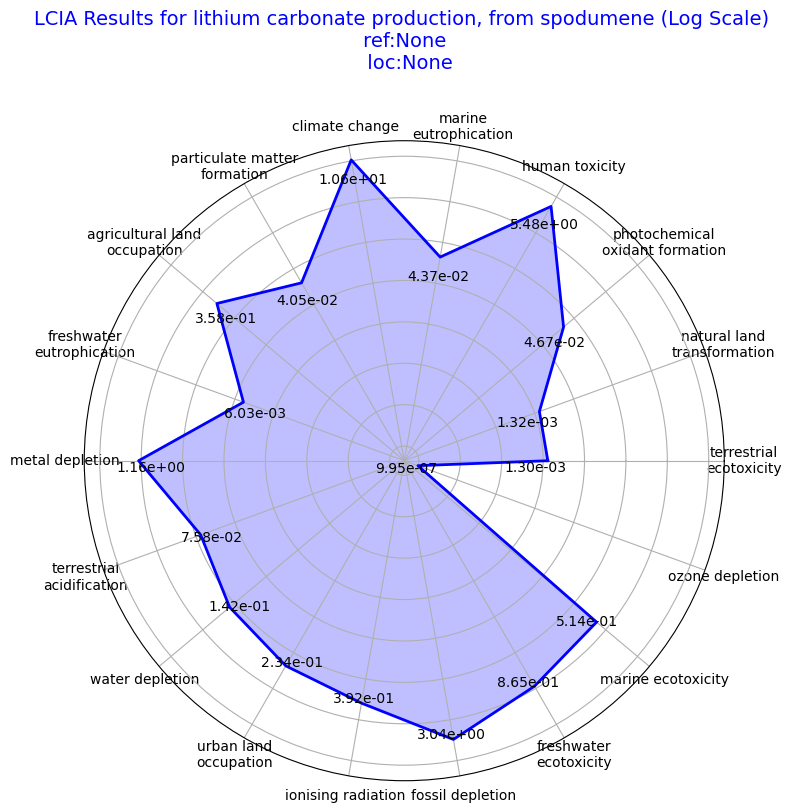

In [24]:
plot_lcia_radar_log(lcia_results, activity_name)

### 3.1.3. lithium carbonate production, from spodumene (RoW)

In [25]:
activity_name = 'lithium carbonate production, from spodumene'
activity = find_activity_by_name_product_location(db_name, activity_name, location='RoW')

In [26]:
lcia_results = run_comprehensive_lcia(activity, recipe_midpoint_h)

('ReCiPe Midpoint (H)', 'terrestrial ecotoxicity', 'TETPinf'): 0.0007860873648870294
('ReCiPe Midpoint (H)', 'natural land transformation', 'NLTP'): 0.0016725357967039395
('ReCiPe Midpoint (H)', 'photochemical oxidant formation', 'POFP'): 0.03554611727779668
('ReCiPe Midpoint (H)', 'human toxicity', 'HTPinf'): 2.926190151956587
('ReCiPe Midpoint (H)', 'marine eutrophication', 'MEP'): 0.03976781489612488
('ReCiPe Midpoint (H)', 'climate change', 'GWP100'): 8.869917489760232
('ReCiPe Midpoint (H)', 'particulate matter formation', 'PMFP'): 0.034699583819507156
('ReCiPe Midpoint (H)', 'agricultural land occupation', 'ALOP'): 0.3743572675907742
('ReCiPe Midpoint (H)', 'freshwater eutrophication', 'FEP'): 0.005867939439985092
('ReCiPe Midpoint (H)', 'metal depletion', 'MDP'): 0.43409771375596684
('ReCiPe Midpoint (H)', 'terrestrial acidification', 'TAP100'): 0.0665165735800254
('ReCiPe Midpoint (H)', 'water depletion', 'WDP'): 0.08520613709365944
('ReCiPe Midpoint (H)', 'urban land occupatio

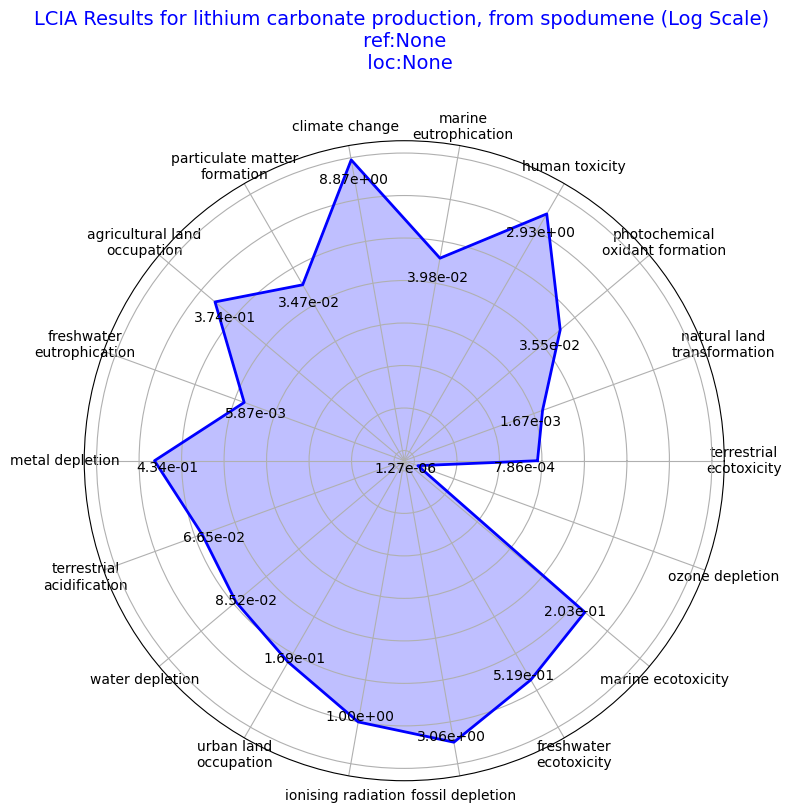

In [27]:
plot_lcia_radar_log(lcia_results, activity_name)

## 3.2. All compared

### 3.2.1. Midpoint

('ReCiPe Midpoint (H)', 'terrestrial ecotoxicity', 'TETPinf'): 0.000279796094022033
('ReCiPe Midpoint (H)', 'natural land transformation', 'NLTP'): 0.0006095939942018074
('ReCiPe Midpoint (H)', 'photochemical oxidant formation', 'POFP'): 0.00998077435120156
('ReCiPe Midpoint (H)', 'human toxicity', 'HTPinf'): 1.4385886686929292
('ReCiPe Midpoint (H)', 'marine eutrophication', 'MEP'): 0.008521145786293535
('ReCiPe Midpoint (H)', 'climate change', 'GWP100'): 2.0750005807610328
('ReCiPe Midpoint (H)', 'particulate matter formation', 'PMFP'): 0.005997127751129825
('ReCiPe Midpoint (H)', 'agricultural land occupation', 'ALOP'): 0.20986216501923322
('ReCiPe Midpoint (H)', 'freshwater eutrophication', 'FEP'): 0.0019771462377554715
('ReCiPe Midpoint (H)', 'metal depletion', 'MDP'): 0.2392236514749893
('ReCiPe Midpoint (H)', 'terrestrial acidification', 'TAP100'): 0.015534855771410254
('ReCiPe Midpoint (H)', 'water depletion', 'WDP'): 0.005319761192097448
('ReCiPe Midpoint (H)', 'urban land occ

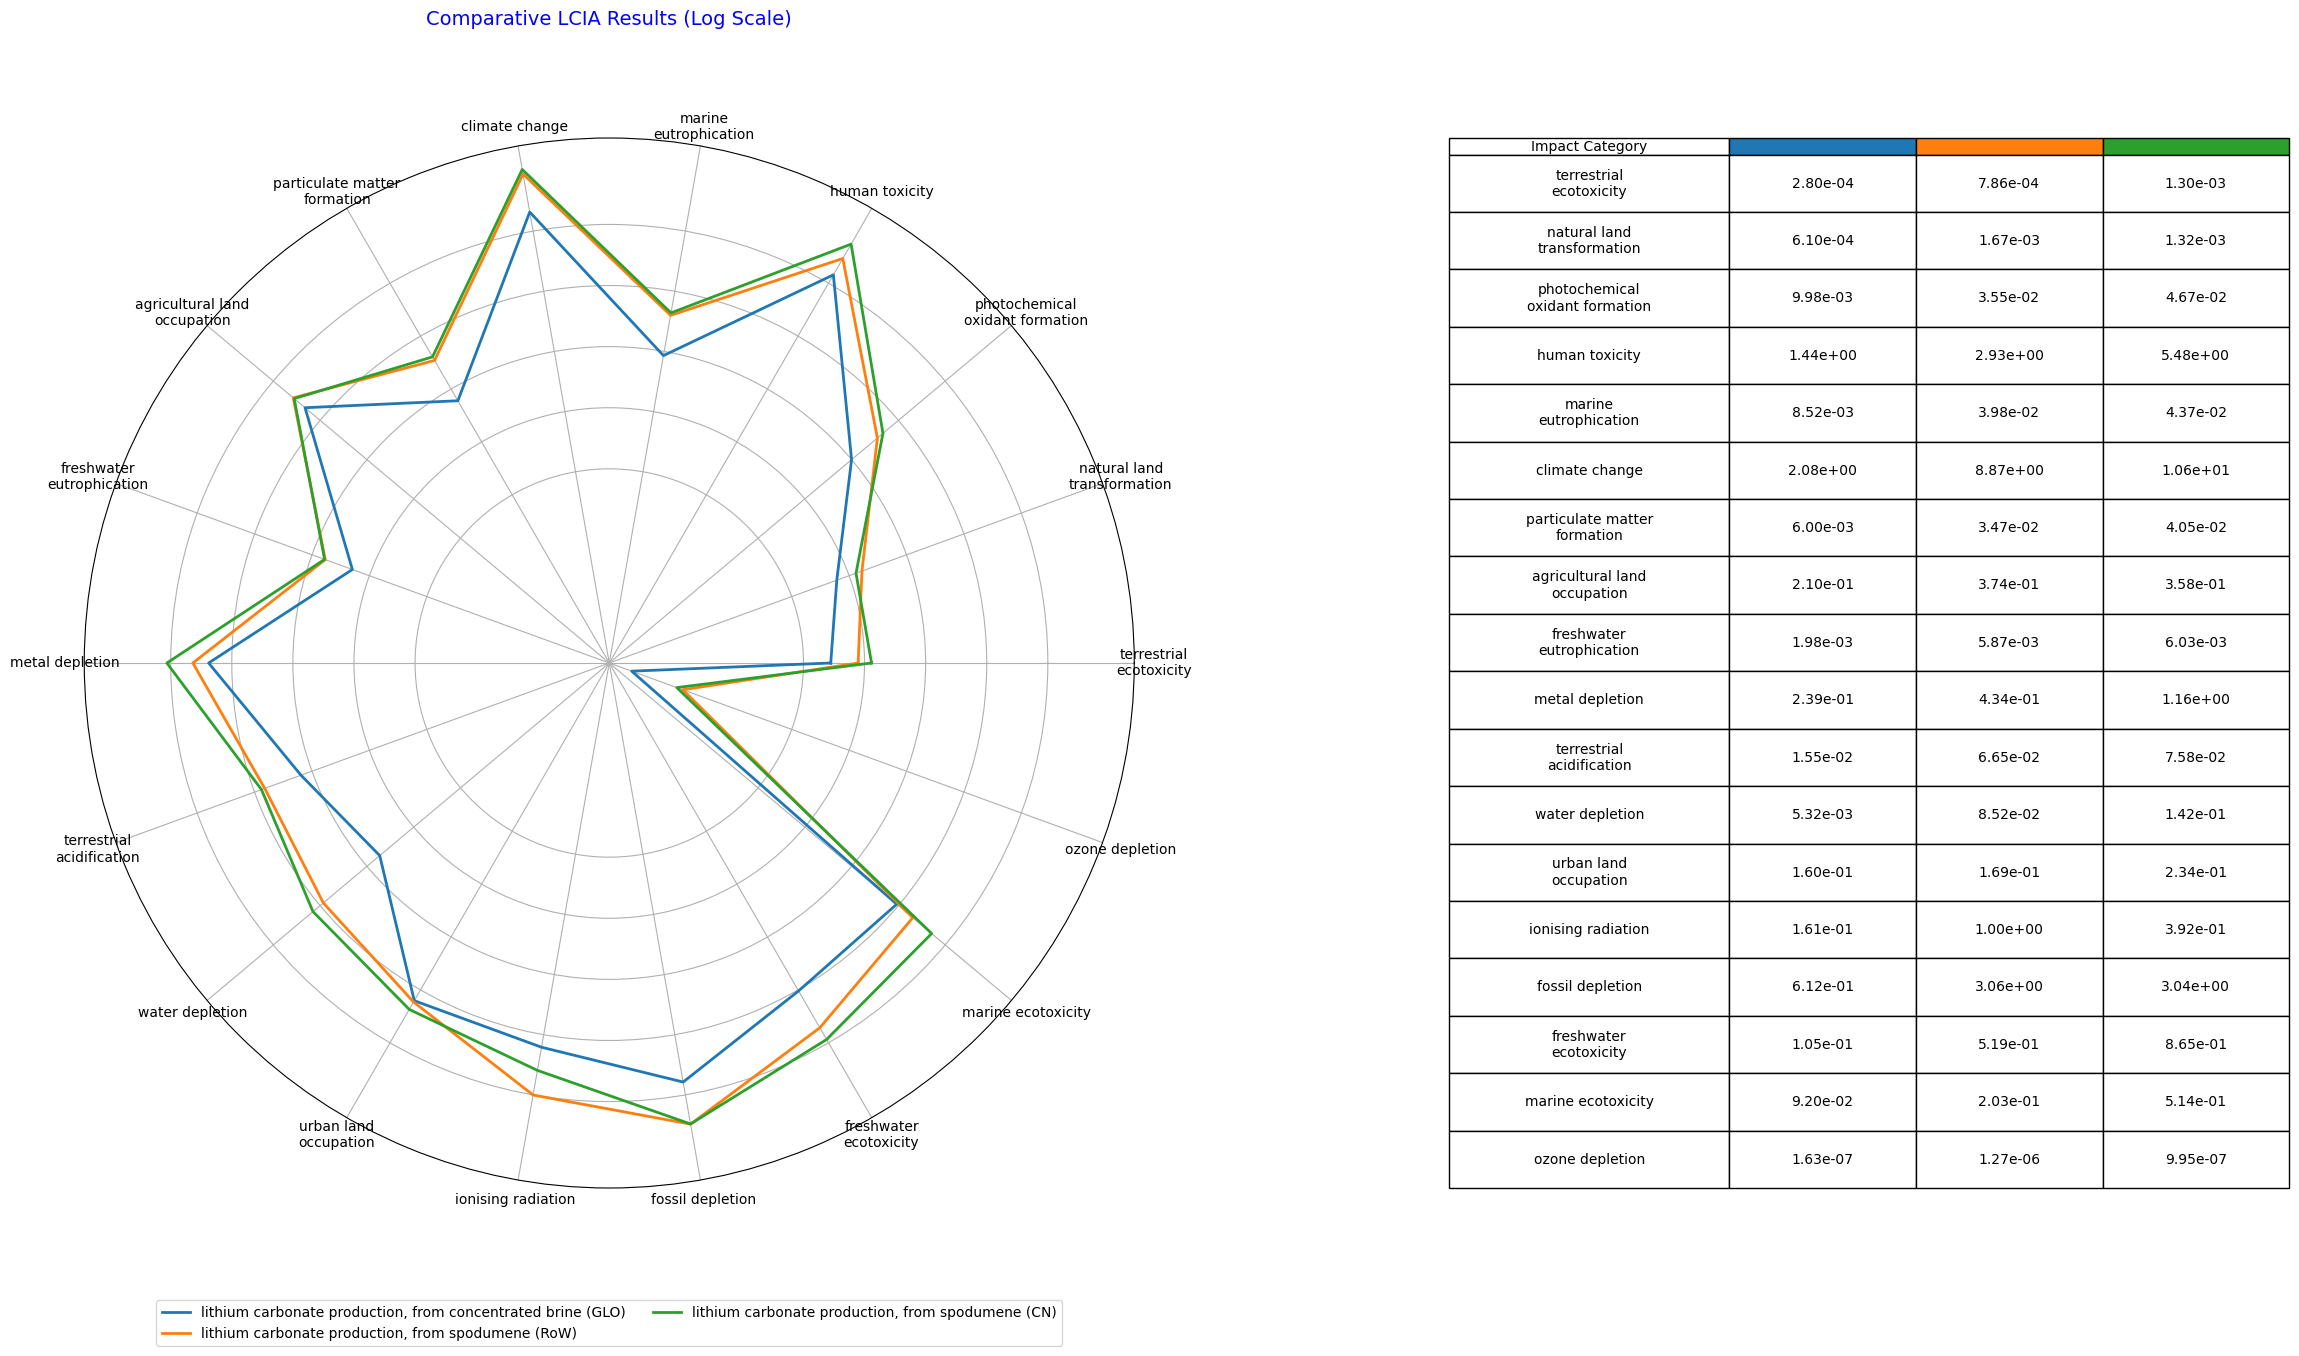

In [28]:
# Run LCIA for all activities

comparative_results = run_comparative_lcia(activities_li, db_name, recipe_midpoint_h, reference_product_lithium)
plot_comparative_radar_log_with_colored_table(comparative_results, recipe_midpoint_h)

# 4. Nickel

## 4.1. Nickel, Class 1

In [29]:
activity_name = "market for nickel, class 1"
reference_product = reference_product_nickel
activity = find_activity_by_name_product_location(db_name, activity_name)

In [30]:
list(activity.exchanges())

[Exchange: 0.3614 ton kilometer 'market group for transport, freight, lorry, unspecified' (ton kilometer, GLO, None) to 'market for nickel, class 1' (kilogram, GLO, None)>,
 Exchange: 1.0 kilogram 'market for nickel, class 1' (kilogram, GLO, None) to 'market for nickel, class 1' (kilogram, GLO, None)>,
 Exchange: 0.3633 ton kilometer 'market for transport, freight, sea, container ship' (ton kilometer, GLO, None) to 'market for nickel, class 1' (kilogram, GLO, None)>,
 Exchange: 0.3448 ton kilometer 'market group for transport, freight train' (ton kilometer, GLO, None) to 'market for nickel, class 1' (kilogram, GLO, None)>,
 Exchange: 0.0363 ton kilometer 'market group for transport, freight, inland waterways, barge' (ton kilometer, GLO, None) to 'market for nickel, class 1' (kilogram, GLO, None)>,
 Exchange: 5.36263530789971e-06 kilogram 'treatment of metal part of electronics scrap, in copper, anode, by electrolytic refining' (kilogram, SE, None) to 'market for nickel, class 1' (kilog

In [31]:
lcia_results = run_comprehensive_lcia(activity, recipe_midpoint_h)

('ReCiPe Midpoint (H)', 'terrestrial ecotoxicity', 'TETPinf'): 0.0181858772519141
('ReCiPe Midpoint (H)', 'natural land transformation', 'NLTP'): 0.006598583214945173
('ReCiPe Midpoint (H)', 'photochemical oxidant formation', 'POFP'): 0.22996775719900656
('ReCiPe Midpoint (H)', 'human toxicity', 'HTPinf'): 31.54463523386889
('ReCiPe Midpoint (H)', 'marine eutrophication', 'MEP'): 0.03725773820863904
('ReCiPe Midpoint (H)', 'climate change', 'GWP100'): 16.665447132368218
('ReCiPe Midpoint (H)', 'particulate matter formation', 'PMFP'): 0.33198831031399734
('ReCiPe Midpoint (H)', 'agricultural land occupation', 'ALOP'): 0.5348035959036807
('ReCiPe Midpoint (H)', 'freshwater eutrophication', 'FEP'): 0.014850347634082607
('ReCiPe Midpoint (H)', 'metal depletion', 'MDP'): 60.513892769581574
('ReCiPe Midpoint (H)', 'terrestrial acidification', 'TAP100'): 1.525974743555525
('ReCiPe Midpoint (H)', 'water depletion', 'WDP'): 0.23541315237531182
('ReCiPe Midpoint (H)', 'urban land occupation', 'U

In [32]:
'''
Let's explore the activities:
'treatment of metal part of electronics scrap, in copper, anode, by electrolytic refining'
'platinum group metal mine operation, ore with high palladium content'
'platinum group metal, extraction and refinery operations'
'processing of nickel-rich materials'
'smelting and refining of nickel concentrate, 16% Ni'
'smelting and refining of nickel concentrate, 7% Ni'
'treatment of metal part of electronics scrap, in copper, anode, by electrolytic refining'
'cobalt production'
'''

"\nLet's explore the activities:\n'treatment of metal part of electronics scrap, in copper, anode, by electrolytic refining'\n'platinum group metal mine operation, ore with high palladium content'\n'platinum group metal, extraction and refinery operations'\n'processing of nickel-rich materials'\n'smelting and refining of nickel concentrate, 16% Ni'\n'smelting and refining of nickel concentrate, 7% Ni'\n'treatment of metal part of electronics scrap, in copper, anode, by electrolytic refining'\n'cobalt production'\n"

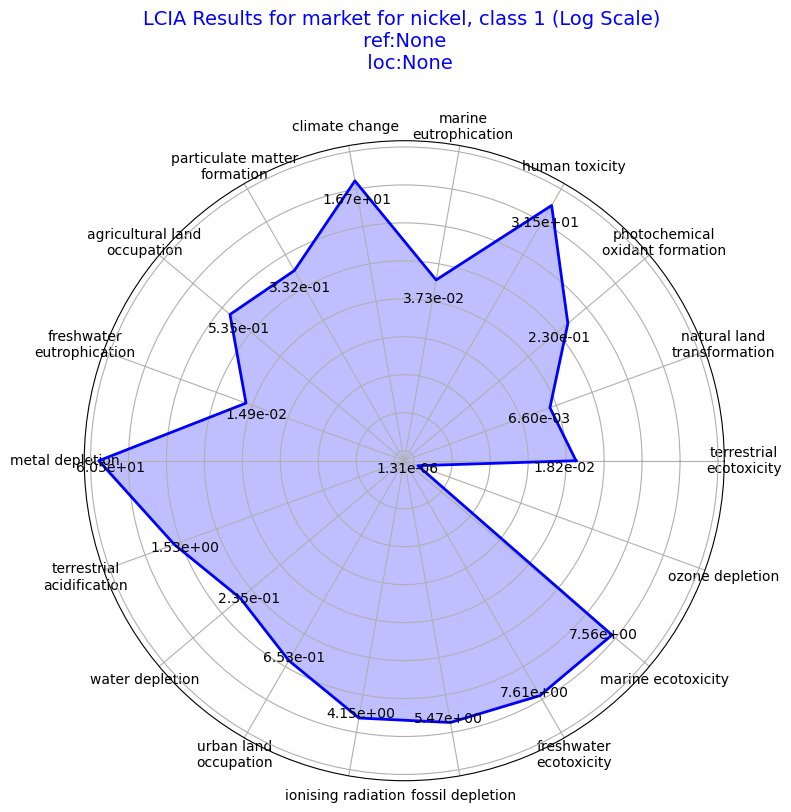

In [33]:
plot_lcia_radar_log(lcia_results, activity_name)

### 4.1.1. treatment of metal part of electronics scrap, in copper, anode, by electrolytic refining

In [34]:
activity_name = 'treatment of metal part of electronics scrap, in copper, anode, by electrolytic refining'

In [35]:
activity = find_activity_by_name_product_location(db_name, activity_name, reference_product)
lcia_results = run_comprehensive_lcia(activity, recipe_midpoint_h)

('ReCiPe Midpoint (H)', 'terrestrial ecotoxicity', 'TETPinf'): 6.0138870671122574e-05
('ReCiPe Midpoint (H)', 'natural land transformation', 'NLTP'): 7.20304147458426e-05
('ReCiPe Midpoint (H)', 'photochemical oxidant formation', 'POFP'): 0.0020172192736063466
('ReCiPe Midpoint (H)', 'human toxicity', 'HTPinf'): 11.438735339864909
('ReCiPe Midpoint (H)', 'marine eutrophication', 'MEP'): 0.0006042015259726495
('ReCiPe Midpoint (H)', 'climate change', 'GWP100'): 1.0150710291036258
('ReCiPe Midpoint (H)', 'particulate matter formation', 'PMFP'): 0.0010706628110376658
('ReCiPe Midpoint (H)', 'agricultural land occupation', 'ALOP'): 0.0073518096098610704
('ReCiPe Midpoint (H)', 'freshwater eutrophication', 'FEP'): 9.079627208614306e-05
('ReCiPe Midpoint (H)', 'metal depletion', 'MDP'): 0.014470073416913871
('ReCiPe Midpoint (H)', 'terrestrial acidification', 'TAP100'): 0.0022314730722373046
('ReCiPe Midpoint (H)', 'water depletion', 'WDP'): 0.001175762319192225
('ReCiPe Midpoint (H)', 'urba

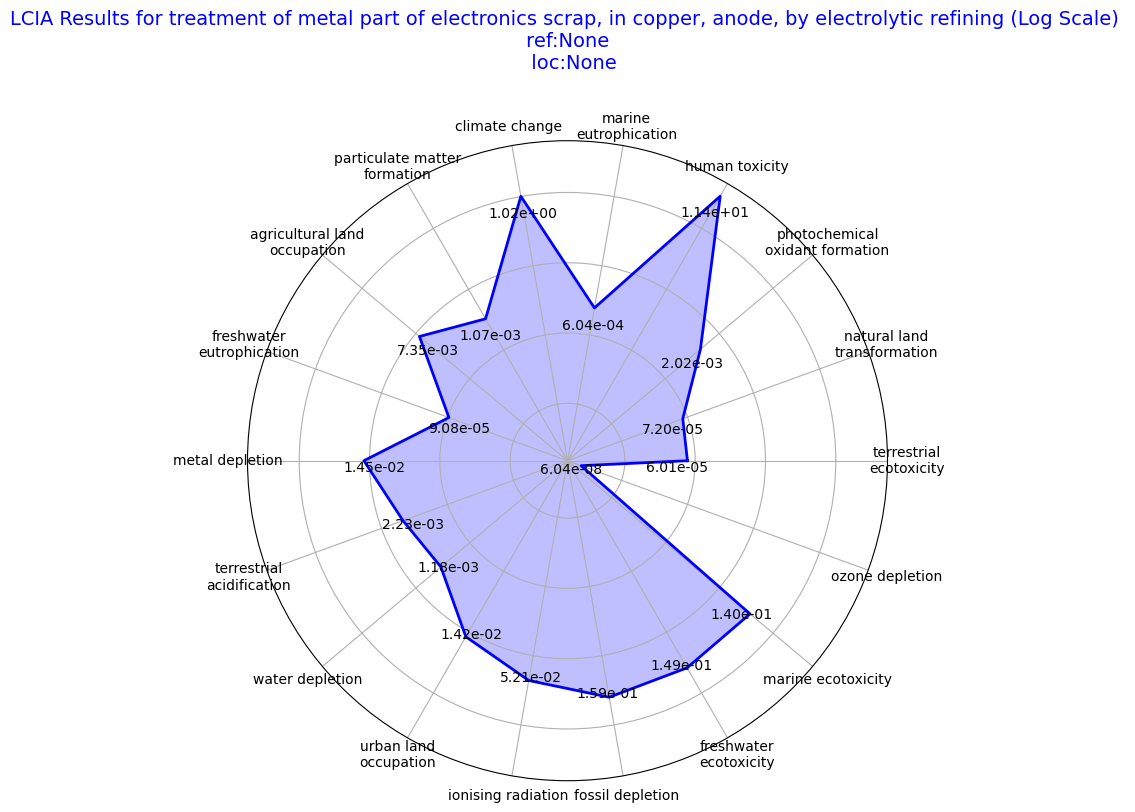

In [36]:
plot_lcia_radar_log(lcia_results, activity_name)

### 4.1.2. platinum group metal mine operation, ore with high palladium content

In [37]:
activity_name = 'platinum group metal mine operation, ore with high palladium content'

In [38]:
activity = find_activity_by_name_product_location(db_name, activity_name, reference_product)
lcia_results = run_comprehensive_lcia(activity, recipe_midpoint_h)

('ReCiPe Midpoint (H)', 'terrestrial ecotoxicity', 'TETPinf'): 0.0014029527210725479
('ReCiPe Midpoint (H)', 'natural land transformation', 'NLTP'): 0.0008144864306491528
('ReCiPe Midpoint (H)', 'photochemical oxidant formation', 'POFP'): 0.6101765038226401
('ReCiPe Midpoint (H)', 'human toxicity', 'HTPinf'): 11.237447838652155
('ReCiPe Midpoint (H)', 'marine eutrophication', 'MEP'): 0.00745356508146779
('ReCiPe Midpoint (H)', 'climate change', 'GWP100'): 8.26228923929516
('ReCiPe Midpoint (H)', 'particulate matter formation', 'PMFP'): 1.475729595368979
('ReCiPe Midpoint (H)', 'agricultural land occupation', 'ALOP'): 0.17857714204639868
('ReCiPe Midpoint (H)', 'freshwater eutrophication', 'FEP'): 0.004782434045587699
('ReCiPe Midpoint (H)', 'metal depletion', 'MDP'): 57.83168594949123
('ReCiPe Midpoint (H)', 'terrestrial acidification', 'TAP100'): 7.294171610256572
('ReCiPe Midpoint (H)', 'water depletion', 'WDP'): 0.2699124712787349
('ReCiPe Midpoint (H)', 'urban land occupation', 'UL

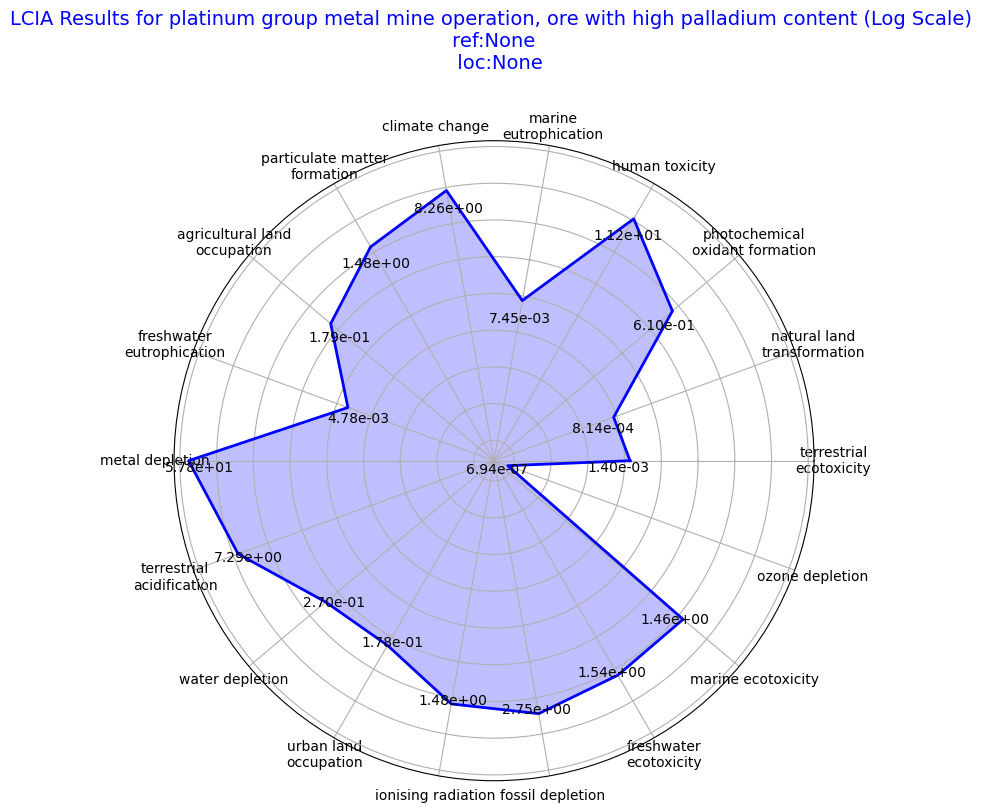

In [39]:
plot_lcia_radar_log(lcia_results, activity_name)

### 4.1.3. platinum group metal, extraction and refinery operations


In [40]:
activity_name = 'platinum group metal, extraction and refinery operations'

In [41]:
activity = find_activity_by_name_product_location(db_name, activity_name, reference_product)
lcia_results = run_comprehensive_lcia(activity, recipe_midpoint_h)

('ReCiPe Midpoint (H)', 'terrestrial ecotoxicity', 'TETPinf'): 0.002592337963451854
('ReCiPe Midpoint (H)', 'natural land transformation', 'NLTP'): 0.05158946767962763
('ReCiPe Midpoint (H)', 'photochemical oxidant formation', 'POFP'): 0.9194876087942337
('ReCiPe Midpoint (H)', 'human toxicity', 'HTPinf'): 192.99896738255555
('ReCiPe Midpoint (H)', 'marine eutrophication', 'MEP'): 0.297747599501345
('ReCiPe Midpoint (H)', 'climate change', 'GWP100'): 49.7003776920104
('ReCiPe Midpoint (H)', 'particulate matter formation', 'PMFP'): 0.3136244887684081
('ReCiPe Midpoint (H)', 'agricultural land occupation', 'ALOP'): 0.6647989359620311
('ReCiPe Midpoint (H)', 'freshwater eutrophication', 'FEP'): 0.06504853363623374
('ReCiPe Midpoint (H)', 'metal depletion', 'MDP'): 79.72484903956882
('ReCiPe Midpoint (H)', 'terrestrial acidification', 'TAP100'): 1.1354332907383946
('ReCiPe Midpoint (H)', 'water depletion', 'WDP'): 0.528519100903807
('ReCiPe Midpoint (H)', 'urban land occupation', 'ULOP'): 

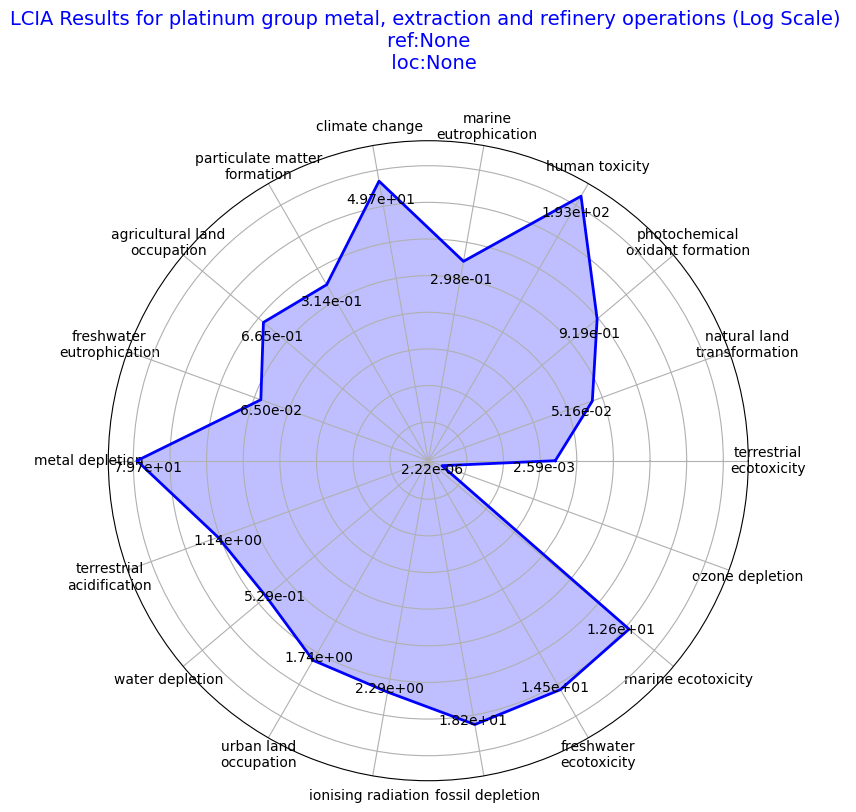

In [42]:
plot_lcia_radar_log(lcia_results, activity_name)

### 4.1.4. processing of nickel-rich materials


In [43]:
activity_name = 'processing of nickel-rich materials'

In [44]:
activity = find_activity_by_name_product_location(db_name, activity_name, reference_product)
lcia_results = run_comprehensive_lcia(activity, recipe_midpoint_h)

('ReCiPe Midpoint (H)', 'terrestrial ecotoxicity', 'TETPinf'): 0.0027436477138383614
('ReCiPe Midpoint (H)', 'natural land transformation', 'NLTP'): 0.004274171620801643
('ReCiPe Midpoint (H)', 'photochemical oxidant formation', 'POFP'): 0.03215909122480383
('ReCiPe Midpoint (H)', 'human toxicity', 'HTPinf'): 17.194315079636322
('ReCiPe Midpoint (H)', 'marine eutrophication', 'MEP'): 0.011977426144184896
('ReCiPe Midpoint (H)', 'climate change', 'GWP100'): 5.292509578989341
('ReCiPe Midpoint (H)', 'particulate matter formation', 'PMFP'): 0.014240498850281443
('ReCiPe Midpoint (H)', 'agricultural land occupation', 'ALOP'): 0.16731646997475874
('ReCiPe Midpoint (H)', 'freshwater eutrophication', 'FEP'): 0.01128810900036791
('ReCiPe Midpoint (H)', 'metal depletion', 'MDP'): 36.02499051563043
('ReCiPe Midpoint (H)', 'terrestrial acidification', 'TAP100'): 0.028717184210519785
('ReCiPe Midpoint (H)', 'water depletion', 'WDP'): 0.11434834273390854
('ReCiPe Midpoint (H)', 'urban land occupati

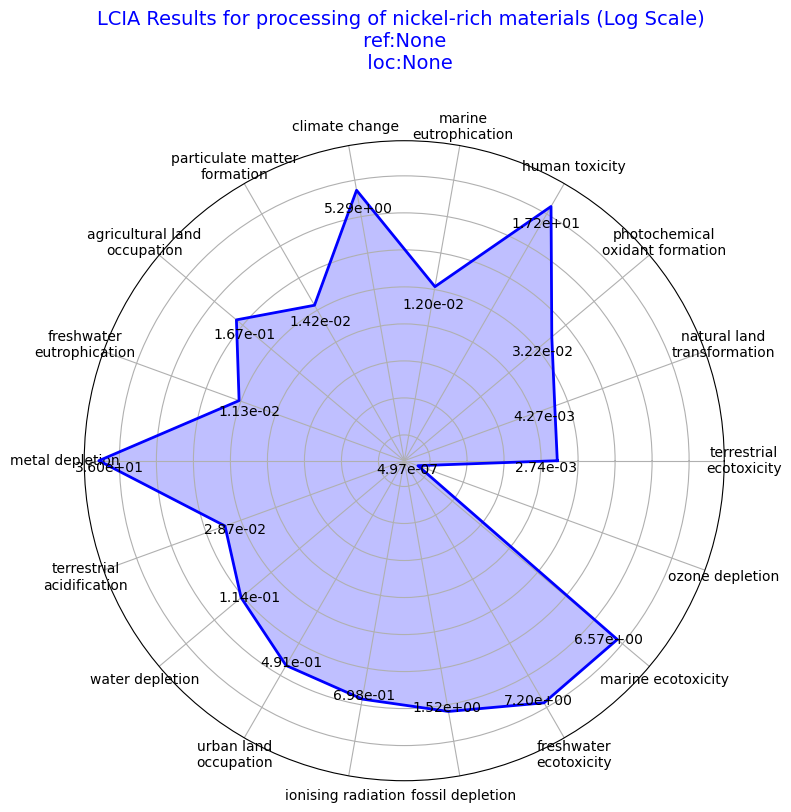

In [45]:
plot_lcia_radar_log(lcia_results, activity_name)

### 4.1.5. smelting and refining of nickel concentrate, 16% Ni

In [46]:
activity_name = 'smelting and refining of nickel concentrate, 16% Ni'

In [47]:
activity = find_activity_by_name_product_location(db_name, activity_name, reference_product)
lcia_results = run_comprehensive_lcia(activity, recipe_midpoint_h)

('ReCiPe Midpoint (H)', 'terrestrial ecotoxicity', 'TETPinf'): 0.002541903970857796
('ReCiPe Midpoint (H)', 'natural land transformation', 'NLTP'): 0.00409426688422211
('ReCiPe Midpoint (H)', 'photochemical oxidant formation', 'POFP'): 0.1512964512003565
('ReCiPe Midpoint (H)', 'human toxicity', 'HTPinf'): 17.023456942564792
('ReCiPe Midpoint (H)', 'marine eutrophication', 'MEP'): 0.015611397222239814
('ReCiPe Midpoint (H)', 'climate change', 'GWP100'): 10.195098001338868
('ReCiPe Midpoint (H)', 'particulate matter formation', 'PMFP'): 0.28748071557332744
('ReCiPe Midpoint (H)', 'agricultural land occupation', 'ALOP'): 0.7390227104503914
('ReCiPe Midpoint (H)', 'freshwater eutrophication', 'FEP'): 0.011435986207742894
('ReCiPe Midpoint (H)', 'metal depletion', 'MDP'): 28.607648188545358
('ReCiPe Midpoint (H)', 'terrestrial acidification', 'TAP100'): 1.3703700533586467
('ReCiPe Midpoint (H)', 'water depletion', 'WDP'): 0.11181702810220503
('ReCiPe Midpoint (H)', 'urban land occupation',

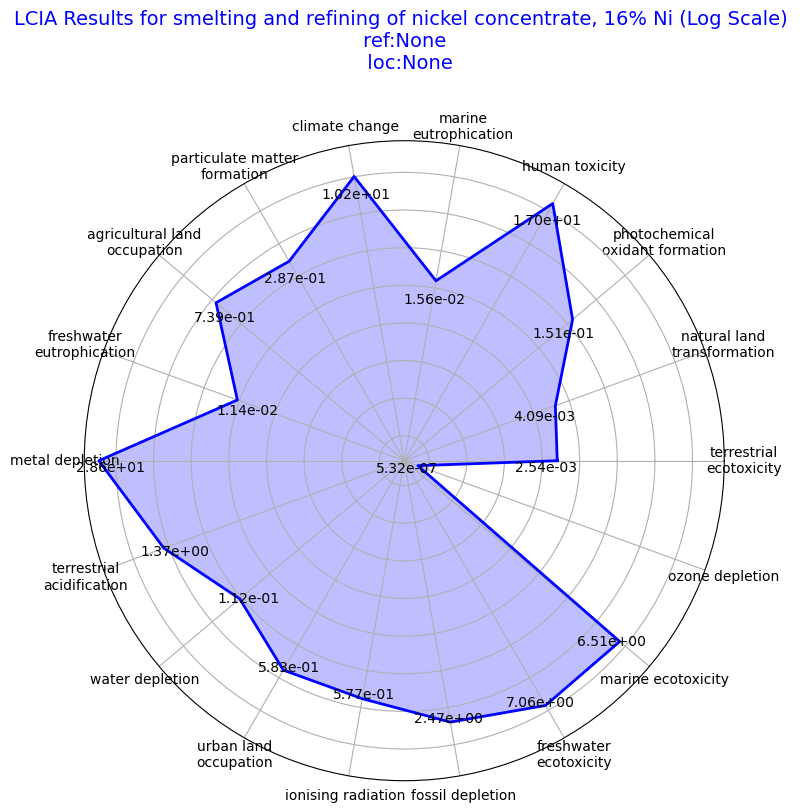

In [48]:
plot_lcia_radar_log(lcia_results, activity_name)

### 4.1.6. smelting and refining of nickel concentrate, 7% Ni


In [49]:
activity_name = 'smelting and refining of nickel concentrate, 7% Ni'

In [50]:
activity = find_activity_by_name_product_location(db_name, activity_name, reference_product)
lcia_results = run_comprehensive_lcia(activity, recipe_midpoint_h)

('ReCiPe Midpoint (H)', 'terrestrial ecotoxicity', 'TETPinf'): 0.002541903970857796
('ReCiPe Midpoint (H)', 'natural land transformation', 'NLTP'): 0.00409426688422211
('ReCiPe Midpoint (H)', 'photochemical oxidant formation', 'POFP'): 0.1512964512003565
('ReCiPe Midpoint (H)', 'human toxicity', 'HTPinf'): 17.023456942564792
('ReCiPe Midpoint (H)', 'marine eutrophication', 'MEP'): 0.015611397222239814
('ReCiPe Midpoint (H)', 'climate change', 'GWP100'): 10.195098001338868
('ReCiPe Midpoint (H)', 'particulate matter formation', 'PMFP'): 0.28748071557332744
('ReCiPe Midpoint (H)', 'agricultural land occupation', 'ALOP'): 0.7390227104503914
('ReCiPe Midpoint (H)', 'freshwater eutrophication', 'FEP'): 0.011435986207742894
('ReCiPe Midpoint (H)', 'metal depletion', 'MDP'): 28.607648188545358
('ReCiPe Midpoint (H)', 'terrestrial acidification', 'TAP100'): 1.3703700533586467
('ReCiPe Midpoint (H)', 'water depletion', 'WDP'): 0.11181702810220503
('ReCiPe Midpoint (H)', 'urban land occupation',

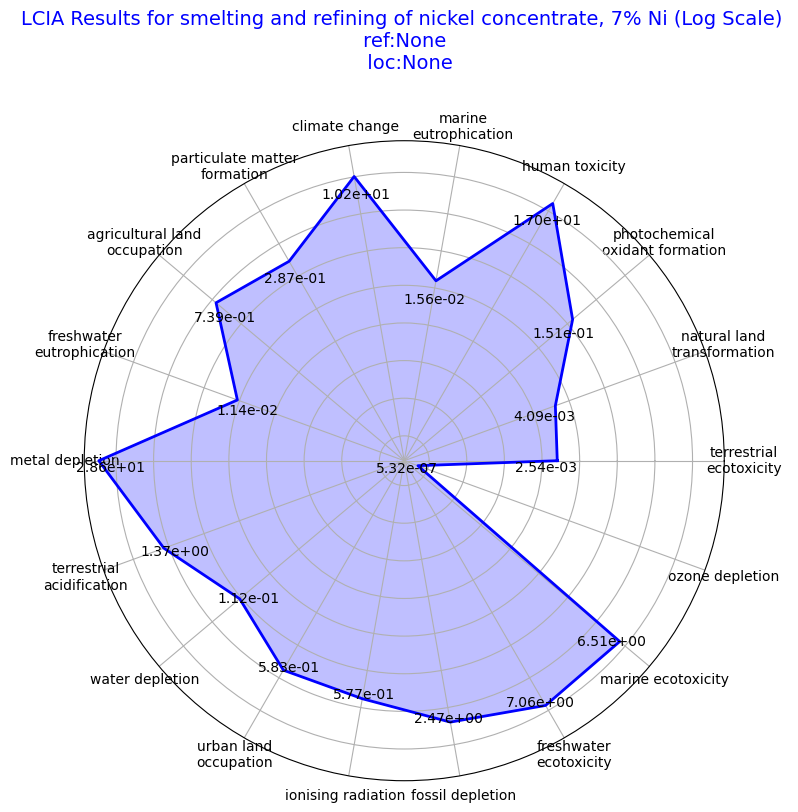

In [51]:
plot_lcia_radar_log(lcia_results, activity_name)

### 4.1.7. treatment of metal part of electronics scrap, in copper, anode, by electrolytic refining


In [52]:
activity_name = 'treatment of metal part of electronics scrap, in copper, anode, by electrolytic refining'

In [53]:
activity = find_activity_by_name_product_location(db_name, activity_name, reference_product)
lcia_results = run_comprehensive_lcia(activity, recipe_midpoint_h)

('ReCiPe Midpoint (H)', 'terrestrial ecotoxicity', 'TETPinf'): 6.0138870671122574e-05
('ReCiPe Midpoint (H)', 'natural land transformation', 'NLTP'): 7.20304147458426e-05
('ReCiPe Midpoint (H)', 'photochemical oxidant formation', 'POFP'): 0.0020172192736063466
('ReCiPe Midpoint (H)', 'human toxicity', 'HTPinf'): 11.438735339864909
('ReCiPe Midpoint (H)', 'marine eutrophication', 'MEP'): 0.0006042015259726495
('ReCiPe Midpoint (H)', 'climate change', 'GWP100'): 1.0150710291036258
('ReCiPe Midpoint (H)', 'particulate matter formation', 'PMFP'): 0.0010706628110376658
('ReCiPe Midpoint (H)', 'agricultural land occupation', 'ALOP'): 0.0073518096098610704
('ReCiPe Midpoint (H)', 'freshwater eutrophication', 'FEP'): 9.079627208614306e-05
('ReCiPe Midpoint (H)', 'metal depletion', 'MDP'): 0.014470073416913871
('ReCiPe Midpoint (H)', 'terrestrial acidification', 'TAP100'): 0.0022314730722373046
('ReCiPe Midpoint (H)', 'water depletion', 'WDP'): 0.001175762319192225
('ReCiPe Midpoint (H)', 'urba

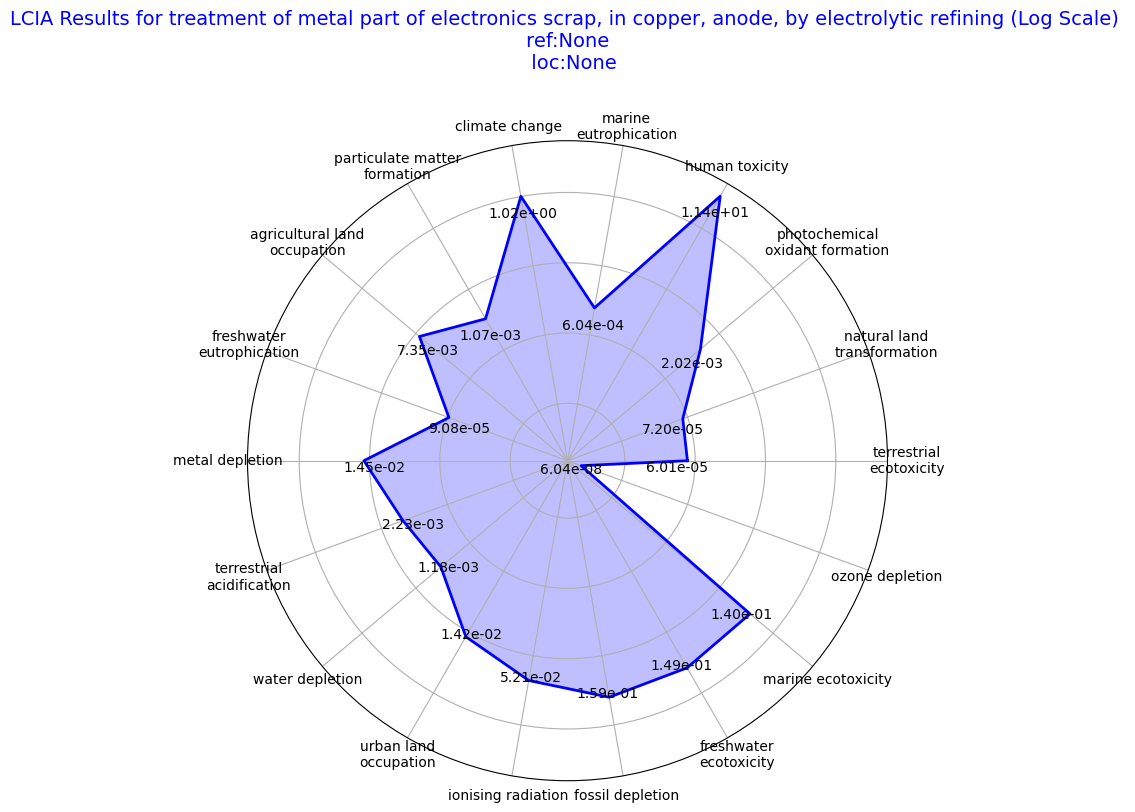

In [54]:
plot_lcia_radar_log(lcia_results, activity_name)

### 4.1.8. cobalt production


In [55]:
activity_name = 'cobalt production'

In [56]:
activity = find_activity_by_name_product_location(db_name, activity_name, reference_product)
lcia_results = run_comprehensive_lcia(activity, recipe_midpoint_h)

('ReCiPe Midpoint (H)', 'terrestrial ecotoxicity', 'TETPinf'): 0.020591303886380592
('ReCiPe Midpoint (H)', 'natural land transformation', 'NLTP'): 0.006056523781210243
('ReCiPe Midpoint (H)', 'photochemical oxidant formation', 'POFP'): 0.06547668162664147
('ReCiPe Midpoint (H)', 'human toxicity', 'HTPinf'): 29.755329163213766
('ReCiPe Midpoint (H)', 'marine eutrophication', 'MEP'): 0.03022796070484047
('ReCiPe Midpoint (H)', 'climate change', 'GWP100'): 17.334145527309673
('ReCiPe Midpoint (H)', 'particulate matter formation', 'PMFP'): 0.06260504736362318
('ReCiPe Midpoint (H)', 'agricultural land occupation', 'ALOP'): 0.725129383706736
('ReCiPe Midpoint (H)', 'freshwater eutrophication', 'FEP'): 0.00727333572442089
('ReCiPe Midpoint (H)', 'metal depletion', 'MDP'): 108.4931958740267
('ReCiPe Midpoint (H)', 'terrestrial acidification', 'TAP100'): 0.1603626233778579
('ReCiPe Midpoint (H)', 'water depletion', 'WDP'): 0.3930469295154789
('ReCiPe Midpoint (H)', 'urban land occupation', 'U

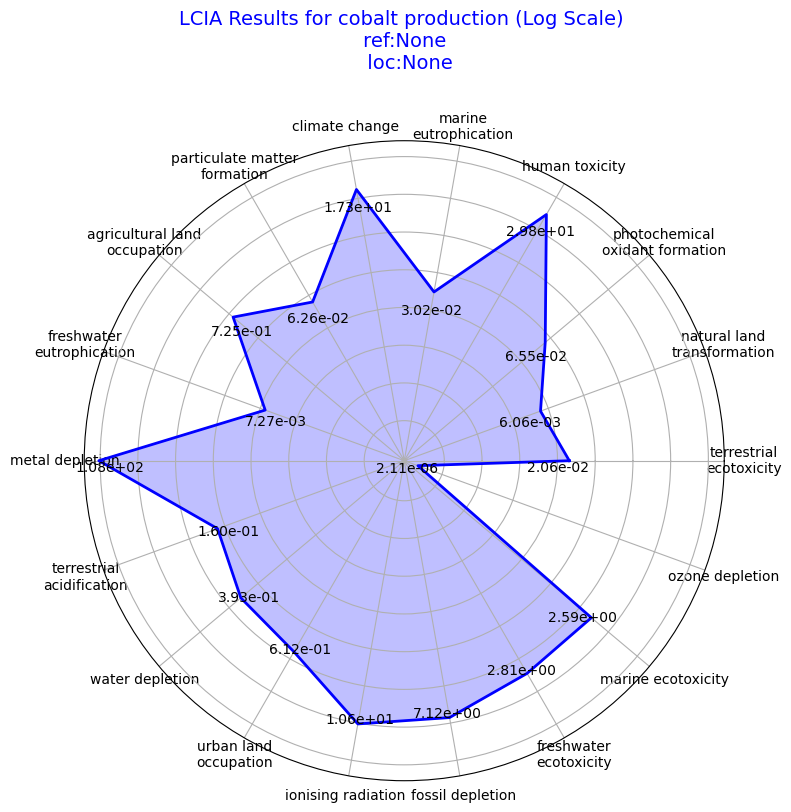

In [57]:
plot_lcia_radar_log(lcia_results, activity_name)

## 4.2. All Compared

In [58]:
activities = activities_ni

In [59]:
# Run LCIA for all activities
comparative_results = run_comparative_lcia(activities, db_name, recipe_midpoint_h, reference_product)

('ReCiPe Midpoint (H)', 'terrestrial ecotoxicity', 'TETPinf'): 6.0138870671122574e-05
('ReCiPe Midpoint (H)', 'natural land transformation', 'NLTP'): 7.20304147458426e-05
('ReCiPe Midpoint (H)', 'photochemical oxidant formation', 'POFP'): 0.0020172192736063466
('ReCiPe Midpoint (H)', 'human toxicity', 'HTPinf'): 11.438735339864909
('ReCiPe Midpoint (H)', 'marine eutrophication', 'MEP'): 0.0006042015259726495
('ReCiPe Midpoint (H)', 'climate change', 'GWP100'): 1.0150710291036258
('ReCiPe Midpoint (H)', 'particulate matter formation', 'PMFP'): 0.0010706628110376658
('ReCiPe Midpoint (H)', 'agricultural land occupation', 'ALOP'): 0.0073518096098610704
('ReCiPe Midpoint (H)', 'freshwater eutrophication', 'FEP'): 9.079627208614306e-05
('ReCiPe Midpoint (H)', 'metal depletion', 'MDP'): 0.014470073416913871
('ReCiPe Midpoint (H)', 'terrestrial acidification', 'TAP100'): 0.0022314730722373046
('ReCiPe Midpoint (H)', 'water depletion', 'WDP'): 0.001175762319192225
('ReCiPe Midpoint (H)', 'urba

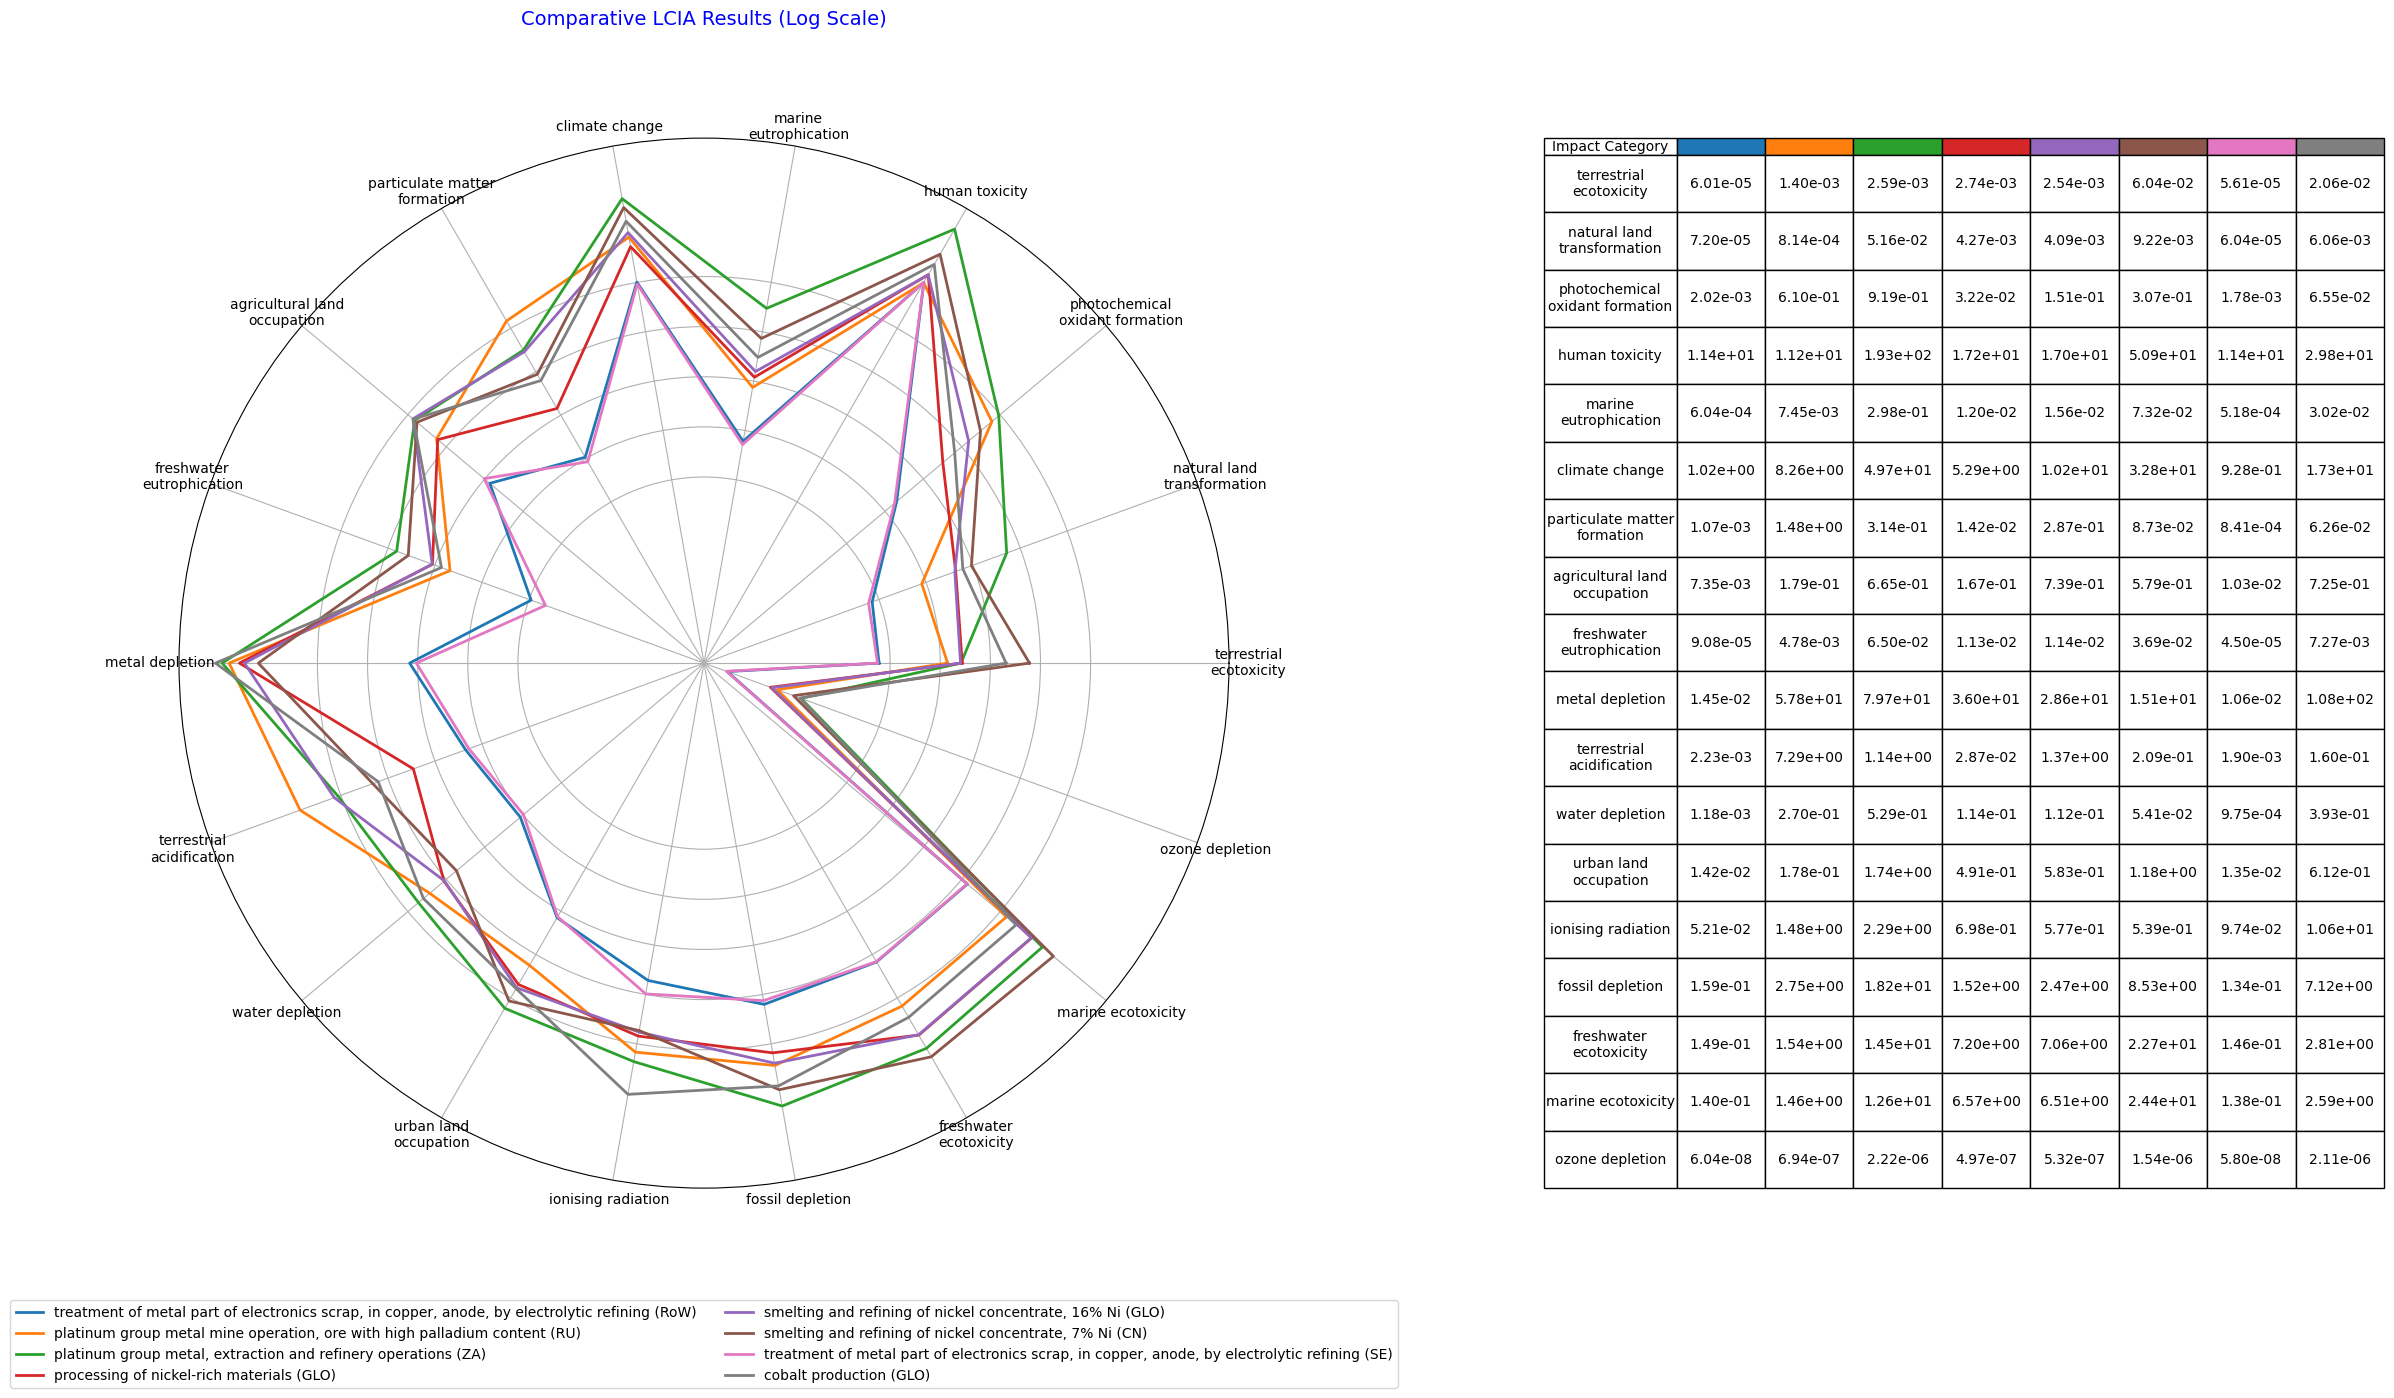

In [60]:
plot_comparative_radar_log_with_colored_table(comparative_results, recipe_midpoint_h)

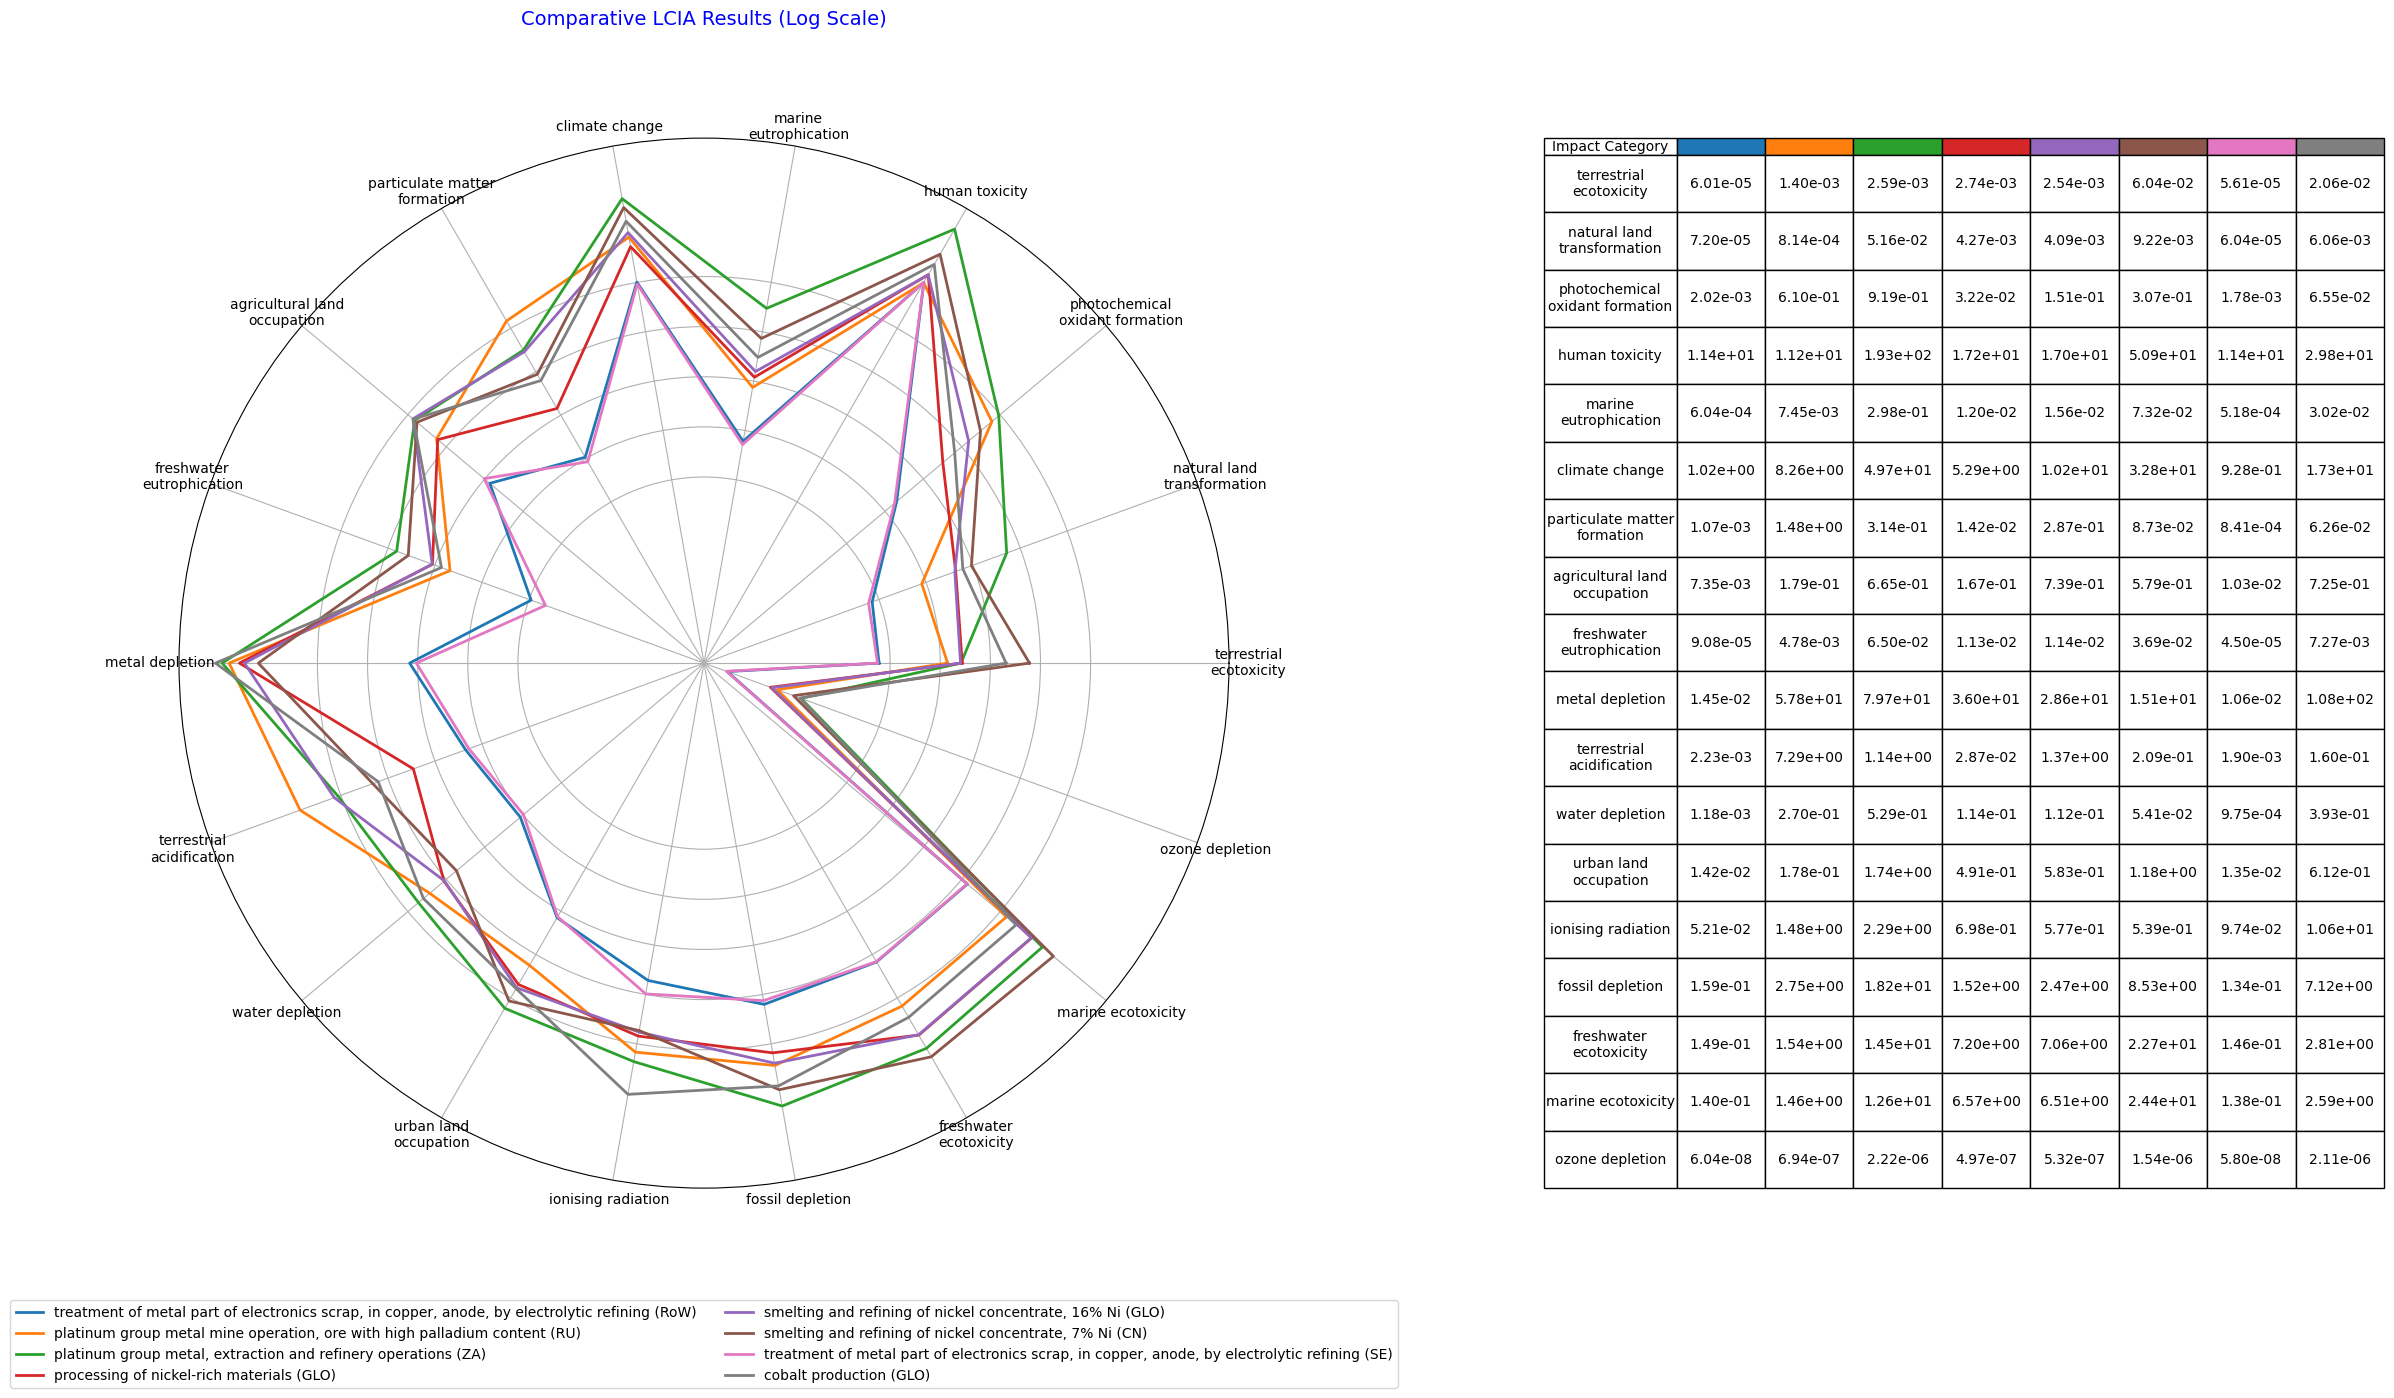

In [61]:
plot_comparative_radar_log_with_colored_table(comparative_results, recipe_midpoint_h)

# 5. Manganese

In [62]:
'''
When looking at NMC-811 hydroxide, we can see "manganese sulfate".
By exploring manganese sulfate, we can see:
-manganese dioxide production
-manganese sulfate production
both generating manganese sulfate

'''

'\nWhen looking at NMC-811 hydroxide, we can see "manganese sulfate".\nBy exploring manganese sulfate, we can see:\n-manganese dioxide production\n-manganese sulfate production\nboth generating manganese sulfate\n\n'

## 5.1. Manganese Sulfate

In [63]:
# Search term from updated SSP1-Base2020 database.
# Updated from:
activity_name = "market for manganese sulfate"
activity = find_activity_by_name_product_location(db_name, activity_name)

In [64]:
list(activity.exchanges())

[Exchange: 0.599 ton kilometer 'market for transport, freight, sea, container ship' (ton kilometer, GLO, None) to 'market for manganese sulfate' (kilogram, GLO, None)>,
 Exchange: 0.2088 ton kilometer 'market group for transport, freight, lorry, unspecified' (ton kilometer, GLO, None) to 'market for manganese sulfate' (kilogram, GLO, None)>,
 Exchange: 0.3091 ton kilometer 'market group for transport, freight train' (ton kilometer, GLO, None) to 'market for manganese sulfate' (kilogram, GLO, None)>,
 Exchange: 0.0246 ton kilometer 'market group for transport, freight, inland waterways, barge' (ton kilometer, GLO, None) to 'market for manganese sulfate' (kilogram, GLO, None)>,
 Exchange: 1.0 kilogram 'market for manganese sulfate' (kilogram, GLO, None) to 'market for manganese sulfate' (kilogram, GLO, None)>,
 Exchange: 0.138175528006351 kilogram 'manganese dioxide production' (kilogram, GLO, None) to 'market for manganese sulfate' (kilogram, GLO, None)>,
 Exchange: 0.861824471993649 ki

In [65]:
lcia_results = run_comprehensive_lcia(activity, recipe_midpoint_h)

('ReCiPe Midpoint (H)', 'terrestrial ecotoxicity', 'TETPinf'): 0.0001066861274240745
('ReCiPe Midpoint (H)', 'natural land transformation', 'NLTP'): 0.00024230828388676015
('ReCiPe Midpoint (H)', 'photochemical oxidant formation', 'POFP'): 0.0047542716145049044
('ReCiPe Midpoint (H)', 'human toxicity', 'HTPinf'): 1.9198619850418124
('ReCiPe Midpoint (H)', 'marine eutrophication', 'MEP'): 0.0011158401915370023
('ReCiPe Midpoint (H)', 'climate change', 'GWP100'): 0.7981935309507165
('ReCiPe Midpoint (H)', 'particulate matter formation', 'PMFP'): 0.005606424962330617
('ReCiPe Midpoint (H)', 'agricultural land occupation', 'ALOP'): 0.035002979447139364
('ReCiPe Midpoint (H)', 'freshwater eutrophication', 'FEP'): 0.0003556475910024782
('ReCiPe Midpoint (H)', 'metal depletion', 'MDP'): 41.796752043673365
('ReCiPe Midpoint (H)', 'terrestrial acidification', 'TAP100'): 0.022205910795353553
('ReCiPe Midpoint (H)', 'water depletion', 'WDP'): 0.005796101714782465
('ReCiPe Midpoint (H)', 'urban la

In [66]:
'''
Let's explore the activities:
'manganese dioxide production'
'manganese sulfate production'
'''

"\nLet's explore the activities:\n'manganese dioxide production'\n'manganese sulfate production'\n"

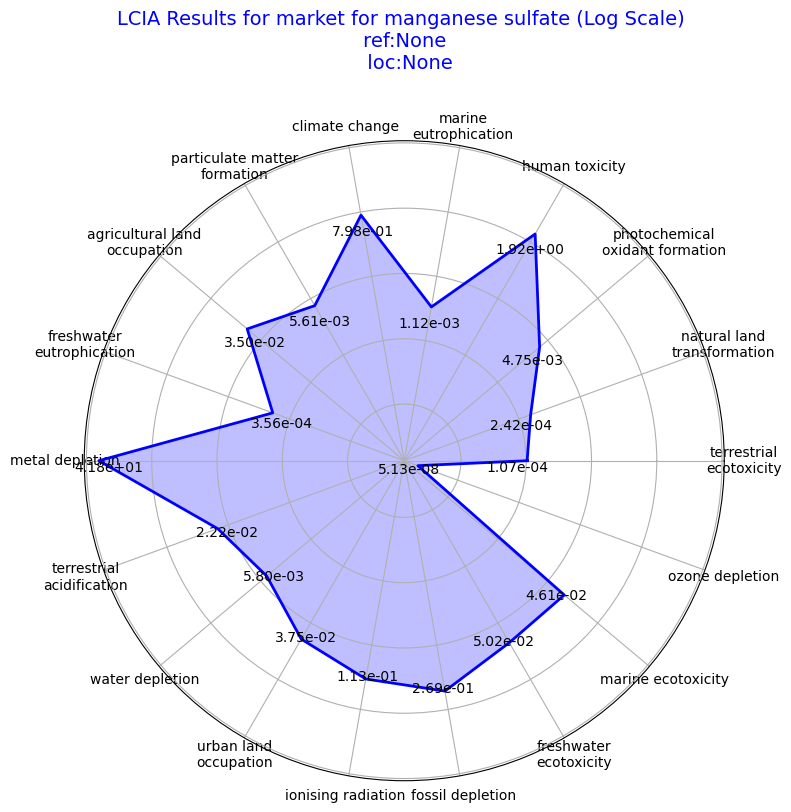

In [67]:
plot_lcia_radar_log(lcia_results, activity_name)

### 5.1.1. Manganese dioxide production

In [68]:
activity_name = 'manganese dioxide production'

In [69]:
activity = find_activity_by_name_product_location(db_name, activity_name)
lcia_results = run_comprehensive_lcia(activity, recipe_midpoint_h)

('ReCiPe Midpoint (H)', 'terrestrial ecotoxicity', 'TETPinf'): 0.00025261576259120306
('ReCiPe Midpoint (H)', 'natural land transformation', 'NLTP'): 0.0005093293126839439
('ReCiPe Midpoint (H)', 'photochemical oxidant formation', 'POFP'): 0.00744439128698589
('ReCiPe Midpoint (H)', 'human toxicity', 'HTPinf'): 5.589793883086671
('ReCiPe Midpoint (H)', 'marine eutrophication', 'MEP'): 0.00254730425646639
('ReCiPe Midpoint (H)', 'climate change', 'GWP100'): 2.5487712609567374
('ReCiPe Midpoint (H)', 'particulate matter formation', 'PMFP'): 0.0049027134998169755
('ReCiPe Midpoint (H)', 'agricultural land occupation', 'ALOP'): 0.11179261663908088
('ReCiPe Midpoint (H)', 'freshwater eutrophication', 'FEP'): 0.0013695554476023152
('ReCiPe Midpoint (H)', 'metal depletion', 'MDP'): 91.32190690398521
('ReCiPe Midpoint (H)', 'terrestrial acidification', 'TAP100'): 0.013531030167962975
('ReCiPe Midpoint (H)', 'water depletion', 'WDP'): 0.012966164235644694
('ReCiPe Midpoint (H)', 'urban land occ

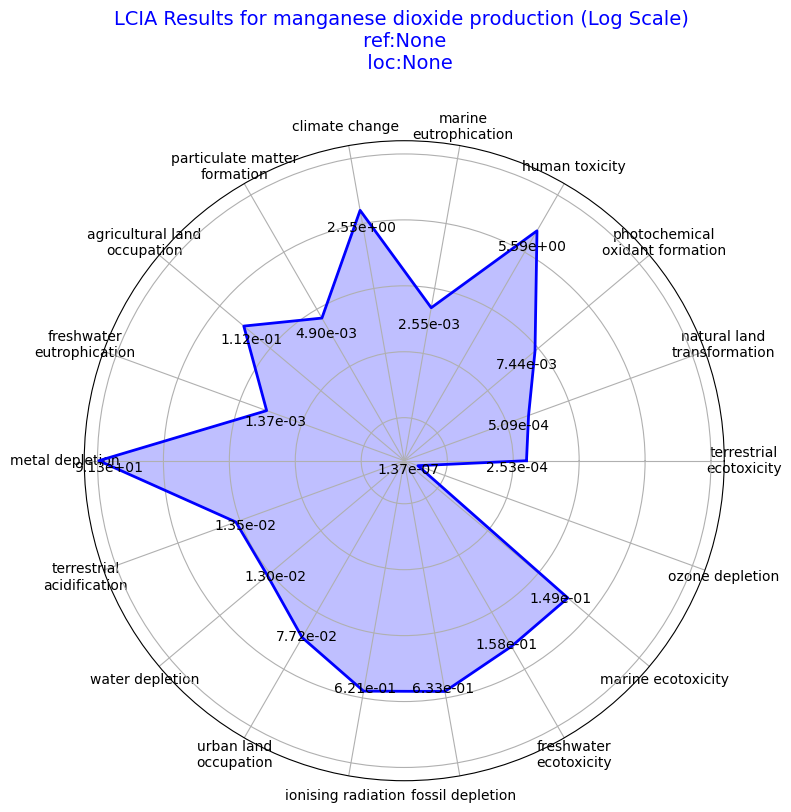

In [70]:
plot_lcia_radar_log(lcia_results, activity_name)

### 5.1.2. Manganese sulfate production

In [71]:
activity_name = 'manganese sulfate production'

In [72]:
activity = find_activity_by_name_product_location(db_name, activity_name)
lcia_results = run_comprehensive_lcia(activity, recipe_midpoint_h)

('ReCiPe Midpoint (H)', 'terrestrial ecotoxicity', 'TETPinf'): 8.8901393882667e-05
('ReCiPe Midpoint (H)', 'natural land transformation', 'NLTP'): 0.00022820126205310418
('ReCiPe Midpoint (H)', 'photochemical oxidant formation', 'POFP'): 0.004484863455411931
('ReCiPe Midpoint (H)', 'human toxicity', 'HTPinf'): 1.8577502120134488
('ReCiPe Midpoint (H)', 'marine eutrophication', 'MEP'): 0.0009454484118726572
('ReCiPe Midpoint (H)', 'climate change', 'GWP100'): 0.7064798602991337
('ReCiPe Midpoint (H)', 'particulate matter formation', 'PMFP'): 0.005993613535225612
('ReCiPe Midpoint (H)', 'agricultural land occupation', 'ALOP'): 0.03247817919150567
('ReCiPe Midpoint (H)', 'freshwater eutrophication', 'FEP'): 0.0003189202622488407
('ReCiPe Midpoint (H)', 'metal depletion', 'MDP'): 42.679703948224265
('ReCiPe Midpoint (H)', 'terrestrial acidification', 'TAP100'): 0.024468201890138243
('ReCiPe Midpoint (H)', 'water depletion', 'WDP'): 0.005833631615264745
('ReCiPe Midpoint (H)', 'urban land o

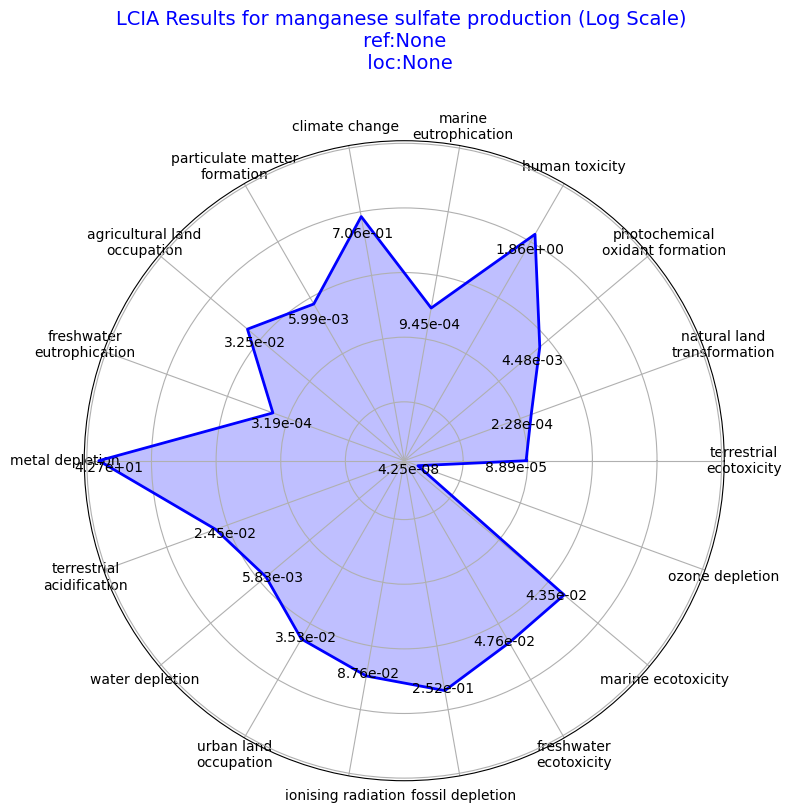

In [73]:
plot_lcia_radar_log(lcia_results, activity_name)

## 5.2. All Compared

In [74]:
activities = activities_mn

In [75]:
# Run LCIA for all activities

comparative_results = run_comparative_lcia(activities, db_name, recipe_midpoint_h)

('ReCiPe Midpoint (H)', 'terrestrial ecotoxicity', 'TETPinf'): 0.00025261576259120306
('ReCiPe Midpoint (H)', 'natural land transformation', 'NLTP'): 0.0005093293126839439
('ReCiPe Midpoint (H)', 'photochemical oxidant formation', 'POFP'): 0.00744439128698589
('ReCiPe Midpoint (H)', 'human toxicity', 'HTPinf'): 5.589793883086671
('ReCiPe Midpoint (H)', 'marine eutrophication', 'MEP'): 0.00254730425646639
('ReCiPe Midpoint (H)', 'climate change', 'GWP100'): 2.5487712609567374
('ReCiPe Midpoint (H)', 'particulate matter formation', 'PMFP'): 0.0049027134998169755
('ReCiPe Midpoint (H)', 'agricultural land occupation', 'ALOP'): 0.11179261663908088
('ReCiPe Midpoint (H)', 'freshwater eutrophication', 'FEP'): 0.0013695554476023152
('ReCiPe Midpoint (H)', 'metal depletion', 'MDP'): 91.32190690398521
('ReCiPe Midpoint (H)', 'terrestrial acidification', 'TAP100'): 0.013531030167962975
('ReCiPe Midpoint (H)', 'water depletion', 'WDP'): 0.012966164235644694
('ReCiPe Midpoint (H)', 'urban land occ

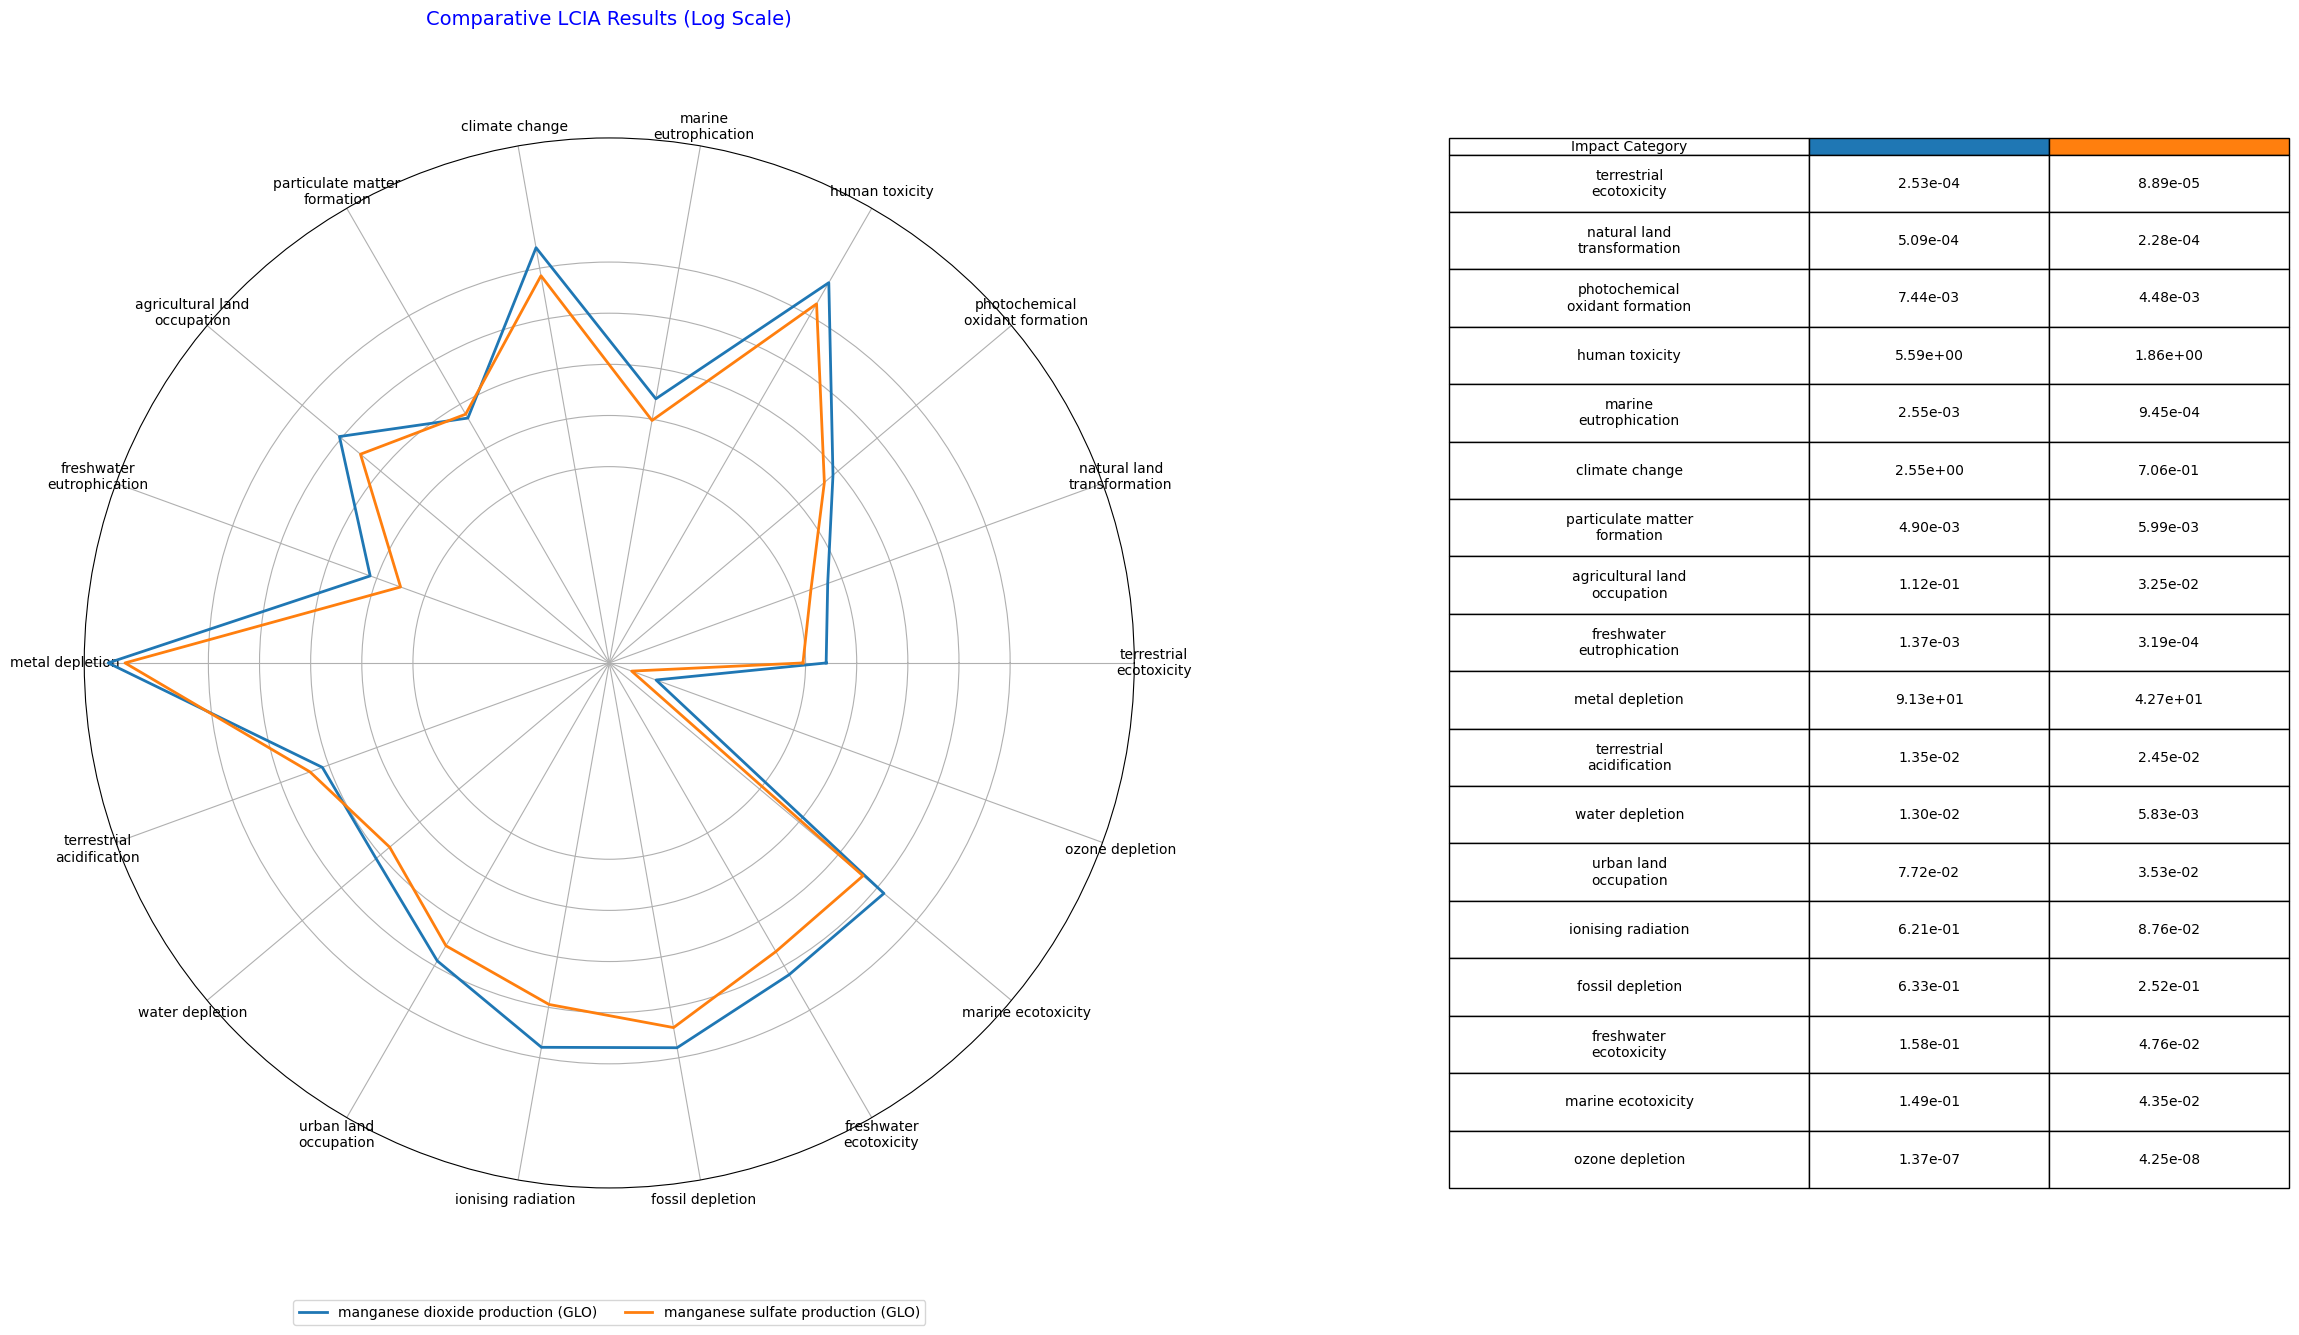

In [76]:
plot_comparative_radar_log_with_colored_table(comparative_results, recipe_midpoint_h)

# 7. battery cell, NMC-811

In [38]:
activity_name = 'battery cell, NMC-811'
activity = find_activity_by_name_product(db_name, activity_name)

In [ ]:
list(activity.exchanges())

In [ ]:
lcia_results = run_comprehensive_lcia(activity, recipe_midpoint_h)
plot_lcia_radar_log(lcia_results, activity_name)